In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Tuple, List
import numpy as np
try:
    import gymnasium as gym
    from gymnasium import spaces
    from gymnasium.utils import seeding
except ImportError as exc:
    raise ImportError(
        "Gymnasium is required for SingleUAVEnv. "
        "Install it with `pip install gymnasium`."
    ) from exc
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
@dataclass
class SingleUAVConfig:
    """Holds tunable parameters for the single-UAV problem."""

    num_customers: int = 5
    num_chargers: int = 1
    map_size: Tuple[float, float] = (100.0, 100.0)
    mission_time: float = 500.0
    max_steps: int = 100
    battery_capacity: float = 250.0
    battery_per_meter: float = 0.5
    drone_speed: float = 15.0
    service_reward: float = 30.0
    charger_time_cost: float = 1.0
    recharge_rate: float = 120.0
    penalty_infeasible: float = 10.0
    penalty_repeat: float = 1.0
    penalty_tardiness: float = 0.1
    deadline_min: float = 80.0
    deadline_max: float = 250.0
    deterministic_seed: int = 42

    def total_nodes(self) -> int:
        # Total nodes include depot, customers, and chargers.
        return 1 + self.num_customers + self.num_chargers


# Represents customer nodes including reward and deadline metadata.
@dataclass
class ServiceNode:
    node_id: int  # Unique identifier matching the observation encoding.
    position: np.ndarray  # 2D coordinate for distance calculations.
    reward: float  # Reward granted when serviced before deadline penalties.
    deadline: float  # Time by which service should be completed.


# Represents charging stations that replenish battery capacity.
@dataclass
class ChargerNode:
    node_id: int  # Unique identifier beyond the customer index range.
    position: np.ndarray  # 2D coordinate used for travel calculations.


# Define the Gymnasium-compatible environment for a single UAV.
class SingleUAVEnv(gym.Env):
    """
    Gymnasium environment for a single UAV performing time-constrained service visits.
    """

    metadata = {"render_modes": ["human"]}  # Declare supported render modes.

    def __init__(self, config: SingleUAVConfig | None = None):
        self.config = config or SingleUAVConfig()  # Store config, defaulting if not provided.
        self.seed(self.config.deterministic_seed)  # Initialize RNGs for reproducibility.
        self.service_nodes: Dict[int, ServiceNode] = {}  # Placeholder for service node metadata.
        self.charger_nodes: Dict[int, ChargerNode] = {}  # Placeholder for charger metadata.
        self.depot_position = np.array(self.config.map_size, dtype=np.float32) / 2.0  # Depot centered.
        self.node_positions = np.zeros((self.config.total_nodes(), 2), dtype=np.float32)  # Full node map.

        self.current_node = 0  # Start at depot node index 0.
        self.battery = self.config.battery_capacity  # Initialize with full battery.
        self.time_remaining = self.config.mission_time  # Start with full mission time.
        self.elapsed_time = 0.0  # Track cumulative time spent moving/charging.
        self.steps = 0  # Counter for number of environment steps taken so far.
        self.visited_mask = np.zeros(self.config.num_customers, dtype=np.int8)  # Track serviced customers.

        self.observation_space = spaces.Dict(  # Define observation components.
            {
                "agent": spaces.Box(
                    low=0.0, high=1.0, shape=(3,), dtype=np.float32
                ),  # Normalized node index, battery fraction, and time fraction.
                "visited": spaces.MultiBinary(self.config.num_customers),  # Indicates serviced customers.
                "deadlines": spaces.Box(
                    low=0.0, high=1.0, shape=(self.config.num_customers,), dtype=np.float32
                ),  # Normalized per-customer deadlines.
                "node_positions": spaces.Box(
                    low=0.0,
                    high=1.0,
                    shape=(self.config.total_nodes(), 2),
                    dtype=np.float32,
                ),  # Normalized XY coordinates for all nodes.
            }
        )
        self.action_space = spaces.Discrete(self.config.total_nodes())  # Agent selects the next node index.
        self._build_nodes()  # Populate positions, deadlines, and charger data.

    def seed(self, seed: int | None = None):
        actual_seed = seed if seed is not None else self.config.deterministic_seed  # Choose seed value.
        self.np_random, _ = seeding.np_random(actual_seed)  # Create Gymnasium-compatible RNG.
        self.rng = np.random.default_rng(actual_seed)  # Create NumPy Generator for sampling.
        return actual_seed  # Return the seed used for reference.

    def reset(self, *, seed: int | None = None, options=None):
        if seed is not None:
            self.seed(seed)  # Reseed RNGs if caller supplies a new seed.
        self._build_nodes()  # Regenerate map layout and deadlines for this episode.
        self.current_node = 0  # Reset UAV position to the depot.
        self.battery = self.config.battery_capacity  # Recharge battery to full.
        self.time_remaining = self.config.mission_time  # Restore the full time budget.
        self.elapsed_time = 0.0  # Clear elapsed-time tracker.
        self.steps = 0  # Reset step counter.
        self.visited_mask = np.zeros(self.config.num_customers, dtype=np.int8)  # Clear visit history.
        obs = self._get_obs()  # Build the initial observation.
        info = {"deadlines": self._normalized_deadlines()}  # Provide normalized deadlines for debugging.
        return obs, info  # Follow Gymnasium API by returning observation and info dict.

    def step(self, action: int):
        assert self.action_space.contains(action), "Invalid action."
        if self.steps >= self.config.max_steps:
            return self._terminal_transition(-self.config.penalty_infeasible, truncated=True)

        target_node = int(action)
        reward = 0.0
        terminated = False

        if target_node == self.current_node:
            reward -= self.config.penalty_repeat
        else:
            distance = self._distance(self.current_node, target_node)
            energy_cost = distance * self.config.battery_per_meter
            time_cost = distance / self.config.drone_speed
            feasible = (
                energy_cost <= self.battery and
                time_cost <= self.time_remaining and
                time_cost > 0
            )

            if not feasible:
                self.battery = max(0.0, self.battery - energy_cost)
                self.time_remaining = max(0.0, self.time_remaining - time_cost)
                reward -= self.config.penalty_infeasible
                terminated = True
            else:
                self.battery -= energy_cost
                self.time_remaining -= time_cost
                self.elapsed_time += time_cost
                self.current_node = target_node

                if self._is_service_node(target_node):
                    reward += self._handle_service(target_node)

                elif self._is_charger_node(target_node):
                    battery_percent = self.battery / self.config.battery_capacity
                    if battery_percent > 0.7:
                        reward -= 20.0  # Penalty for charging when not needed
                    elif battery_percent > 0.5:
                        reward -= 10.0
                    reward += self._handle_charge()

                else:
                    if self.visited_mask.all():
                        # All customers served AND returned to depot!
                        reward += 20.0  # Bonus for proper completion
                        terminated = True
                    else:
                        customers_remaining = self.config.num_customers - np.sum(self.visited_mask)
                        reward -= 15.0 * customers_remaining  # Harsh penalty!
                        # Don't terminate - let agent continue from depot
                        terminated = False

        self.steps += 1
        # Don't automatically end when all customers served
        # Only end when: depot return, time out, or infeasible
        if self.time_remaining <= 0:
            # Ran out of time - check if completed
            if not self.visited_mask.all():
                reward -= 10.0  # Didn't complete mission
            elif self.current_node != 0:
                reward -= 15.0  # Completed but didn't return!
            terminated = True

        obs = self._get_obs()
        info = {
            "elapsed_time": self.elapsed_time,
            "returned_to_depot": self.current_node == 0,
            "completed": self.visited_mask.all(),
        }

        return obs, reward, terminated, False, info

    def render(self):
        # Print a simple textual summary of the UAV status for debugging.
        print(
            f"Step {self.steps} | Node {self.current_node} | "
            f"Battery {self.battery:.1f}/{self.config.battery_capacity} | "
            f"Time left {self.time_remaining:.1f}"
        )

    # ----------------------- Helpers ----------------------- #

    def _build_nodes(self):
        width, height = self.config.map_size  # Unpack map dimensions for readability.
        depot = self.depot_position.reshape(1, 2)  # Keep depot as a (1,2) array for stacking.
        customer_positions = self.rng.uniform(
            low=[0.0, 0.0], high=[width, height], size=(self.config.num_customers, 2)
        )  # Sample customer coordinates uniformly over the map.
        charger_positions = self.rng.uniform(
            low=[0.0, 0.0], high=[width, height], size=(self.config.num_chargers, 2)
        )  # Sample charger coordinates similarly.
        self.node_positions = np.vstack([depot, customer_positions, charger_positions]).astype(
            np.float32
        )  # Stack depot, customers, and chargers into one array.

        self.service_nodes = {}  # Reset service node registry.
        for idx in range(self.config.num_customers):
            node_id = 1 + idx  # Customer IDs start at 1 since depot is 0.
            deadline = self.rng.uniform(self.config.deadline_min, self.config.deadline_max)  # Sample deadline.
            self.service_nodes[node_id] = ServiceNode(
                node_id=node_id,
                position=self.node_positions[node_id],
                reward=self.config.service_reward,
                deadline=deadline,
            )  # Store metadata for each service node.

        self.charger_nodes = {}  # Reset charger registry.
        charger_offset = 1 + self.config.num_customers  # Chargers come after depot and customers.
        for idx in range(self.config.num_chargers):
            node_id = charger_offset + idx  # Compute charger node id.
            self.charger_nodes[node_id] = ChargerNode(
                node_id=node_id, position=self.node_positions[node_id]
            )  # Store charger metadata for future lookups.

    def _handle_service(self, node_id: int) -> float:
        service_idx = node_id - 1  # Convert node id into zero-based customer index.
        reward = 0.0  # Initialize reward for this service action.
        if self.visited_mask[service_idx]:
            reward -= self.config.penalty_repeat  # Penalize duplicate visits.
        else:
            node = self.service_nodes[node_id]  # Fetch metadata for the service node.
            lateness = max(0.0, self.elapsed_time - node.deadline)  # Compute time past deadline.
            reward += node.reward - self.config.penalty_tardiness * lateness  # Reward minus lateness penalty.
            self.visited_mask[service_idx] = 1  # Mark the customer as serviced.
        return reward  # Return the net reward from servicing.

    def _handle_charge(self) -> float:
        self.time_remaining = max(0.0, self.time_remaining - self.config.charger_time_cost)  # Deduct charging time.
        self.elapsed_time += self.config.charger_time_cost  # Account for time spent charging.
        self.battery = min(
            self.config.battery_capacity, self.battery + self.config.recharge_rate
        )  # Increase battery up to capacity.
        return 0.0  # Charging itself yields no immediate reward.

    def _distance(self, src: int, dst: int) -> float:
        if dst >= self.config.total_nodes():
            return np.inf  # Out-of-range nodes are treated as infinitely far/invalid.
        return float(np.linalg.norm(self.node_positions[src] - self.node_positions[dst]))  # Euclidean distance.

    def _is_service_node(self, node_id: int) -> bool:
        return 1 <= node_id < 1 + self.config.num_customers  # True when node id belongs to a customer.

    def _is_charger_node(self, node_id: int) -> bool:
        start = 1 + self.config.num_customers  # Charger ids begin after service nodes.
        return start <= node_id < start + self.config.num_chargers  # True when node id is a charger.

    def _get_obs(self) -> Dict[str, np.ndarray]:
        node_norm = self.current_node / max(1, self.config.total_nodes() - 1)  # Normalize node id to [0,1].
        agent = np.array(
            [
                node_norm,
                self.battery / max(1.0, self.config.battery_capacity),
                self.time_remaining / max(1.0, self.config.mission_time),
            ],
            dtype=np.float32,
        )  # Pack normalized agent state.
        obs = {
            "agent": agent,  # Include agent summary vector.
            "visited": self.visited_mask.copy(),  # Provide which customers have been served.
            "deadlines": self._normalized_deadlines(),  # Include normalized deadlines.
            "node_positions": self._normalized_positions(),  # Include normalized coordinates.
        }  # Combine into a dict matching observation_space.
        return obs  # Return the structured observation.

    def _normalized_positions(self):
        width, height = self.config.map_size  # Fetch map extents for normalization.
        denom = np.array([width, height], dtype=np.float32)  # Build divisor vector.
        return self.node_positions / denom  # Scale coordinates into [0,1].

    def _normalized_deadlines(self):
        deadlines = np.zeros(self.config.num_customers, dtype=np.float32)  # Prepare output vector.
        for node_id, node in self.service_nodes.items():
            idx = node_id - 1  # Convert node id to zero-based index.
            deadlines[idx] = node.deadline / max(1.0, self.config.deadline_max)  # Normalize deadline.
        return deadlines  # Return normalized deadlines array.

    def _terminal_transition(self, reward: float, truncated: bool = False):
        obs = self._get_obs()
        info = {
            "elapsed_time": self.elapsed_time,
            "returned_to_depot": self.current_node == 0,
            "completed": self.visited_mask.all(),
        }
        return obs, reward, True, truncated, info


# Provide a deterministic configuration for small-scale testing.
SMALL_ENV_CONFIG = SingleUAVConfig(
    num_customers=5,
    num_chargers=1,
    mission_time=500.0,
    battery_capacity=250.0,
    battery_per_meter=0.5,
    drone_speed=15.0,
    service_reward=30.0,
    charger_time_cost=1.0,
    recharge_rate=120.0,
    penalty_infeasible=10.0,
    penalty_repeat=1.0,
    penalty_tardiness=0.1,
    deadline_min=80.0,
    deadline_max=250.0,
    max_steps=100,
    deterministic_seed=42,
)


# Simple factory function to create the deterministic test environment.
def make_single_uav_env() -> SingleUAVEnv:
    """Factory for the deterministic single-UAV test environment."""
    return SingleUAVEnv(SMALL_ENV_CONFIG)  # Instantiate the env with the test config.

In [ ]:
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])


class ReplayBuffer:
    """Experience replay buffer for DQN."""
    def __init__(self, capacity: int = 20000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


class DQNetwork(nn.Module):
    """Deep Q-Network."""
    def __init__(self, state_dim: int, action_dim: int):
        super(DQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class SingleUAVDQNAgent:
    """DQN agent with action masking for single UAV routing."""

    def __init__(
        self,
        env,  # Environment reference for action masking
        state_dim: int,
        action_dim: int,
        learning_rate: float = 1e-4,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.1,
        epsilon_decay: float = 0.998,
        buffer_size: int = 20000,
        batch_size: int = 128,
        target_update_freq: int = 200,
        polyak_tau: float = 0.005,
    ):
        self.env = env
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.polyak_tau = polyak_tau

        self.policy_net = DQNetwork(state_dim, action_dim)
        self.target_net = DQNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.update_counter = 0

    def flatten_obs(self, obs: dict) -> np.ndarray:
        """Flatten dictionary observation to vector."""
        return np.concatenate([
            obs['agent'],
            obs['visited'].flatten(),
            obs['deadlines'].flatten(),
            obs['node_positions'].flatten(),
        ])

    def get_action_mask(self, obs: dict) -> np.ndarray:
        """
        Create feasible action mask - KEY IMPROVEMENT from legacy code.
        Returns: boolean array where True = action is valid
        """
        mask = np.ones(self.action_dim, dtype=bool)

        current_node = self.env.current_node
        visited = obs['visited']
        battery = obs['agent'][1] * self.env.config.battery_capacity
        time_left = obs['agent'][2] * self.env.config.mission_time

        for action in range(self.action_dim):
            # Can't stay in same place
            if action == current_node:
                mask[action] = False
                continue

            # Can't revisit already-served customers (like legacy vList)
            if self._is_customer(action) and visited[action - 1] == 1:
                mask[action] = False
                continue

            # Check battery and time feasibility
            distance = self.env._distance(current_node, action)
            energy_needed = distance * self.env.config.battery_per_meter
            time_needed = distance / self.env.config.drone_speed

            if energy_needed > battery or time_needed > time_left:
                mask[action] = False
                continue

        # Safety: ensure at least one action is valid
        if not mask.any():
            mask[0] = True

        return mask

    def _is_customer(self, node_id: int) -> bool:
        """Check if node is a customer."""
        return 1 <= node_id < 1 + self.env.config.num_customers

    def select_action(self, obs: dict, training: bool = True) -> int:
        """Select action with action masking - only considers valid actions."""
        state = self.flatten_obs(obs)
        action_mask = self.get_action_mask(obs)
        valid_actions = np.where(action_mask)[0]

        if training and random.random() < self.epsilon:
            # Smart exploration: prefer unvisited customers from valid actions
            visited = obs['visited']
            unvisited_customers = [a for a in valid_actions
                                  if self._is_customer(a) and visited[a-1] == 0]

            if unvisited_customers and random.random() < 0.8:
                return random.choice(unvisited_customers)
            else:
                return random.choice(valid_actions)

        # Greedy: select best Q-value among valid actions only
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_net(state_tensor).squeeze().numpy()

            # Mask out invalid actions
            q_values[~action_mask] = -np.inf
            return int(np.argmax(q_values))

    def store_transition(self, obs, action, reward, next_obs, done):
        """Store transition in replay buffer."""
        state = self.flatten_obs(obs)
        next_state = self.flatten_obs(next_obs)
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self) -> float:
        """Update Q-network with stability improvements."""
        if len(self.replay_buffer) < self.batch_size:
            return 0.0

        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.FloatTensor(np.array(batch.state))
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state))
        done_batch = torch.FloatTensor(batch.done)

        current_q = self.policy_net(state_batch).gather(1, action_batch).squeeze()

        with torch.no_grad():
            next_q = self.target_net(next_state_batch).max(1)[0]
            target_q = reward_batch + (1 - done_batch) * self.gamma * next_q
            target_q = torch.clamp(target_q, -300, 300)

        loss = F.smooth_l1_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()

        # Soft target update (Polyak averaging)
        self.update_counter += 1
        for target_param, policy_param in zip(self.target_net.parameters(),
                                               self.policy_net.parameters()):
            target_param.data.copy_(
                self.polyak_tau * policy_param.data +
                (1 - self.polyak_tau) * target_param.data
            )

        # Periodic hard update
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class SingleUAVDQNTrainer:
    """Trainer with action masking and legacy code improvements."""

    def __init__(self, env, config: dict = None):
        self.env = env

        obs, _ = env.reset()
        self.state_dim = (
            obs['agent'].shape[0] +
            obs['visited'].flatten().shape[0] +
            obs['deadlines'].flatten().shape[0] +
            obs['node_positions'].flatten().shape[0]
        )
        self.action_dim = env.action_space.n

        print(f"\nTrainer Initialization:")
        print(f"  State dimension: {self.state_dim}")
        print(f"  Action dimension: {self.action_dim}")
        print(f"  Environment: {env.config.num_customers} customers, {env.config.num_chargers} chargers\n")

        default_config = {
            'learning_rate': 1e-4,
            'gamma': 0.99,
            'epsilon_start': 1.0,
            'epsilon_end': 0.1,
            'epsilon_decay': 0.998,
            'buffer_size': 20000,
            'batch_size': 128,
            'target_update_freq': 200,
            'polyak_tau': 0.005,
        }
        self.config = {**default_config, **(config or {})}

        # IMPORTANT: Pass env to agent for action masking
        self.agent = SingleUAVDQNAgent(env, self.state_dim, self.action_dim, **self.config)

        self.episode_rewards = []
        self.episode_losses = []
        self.episode_customers_served = []
        self.episode_steps = []
        self.epsilon_history = []

    def train(self, num_episodes: int = 2000, log_interval: int = 50, warmup_episodes: int = 200):
        """Train with action masking and efficiency-based rewards."""
        print("="*80)
        print(f"TRAINING: {num_episodes} episodes (warmup: {warmup_episodes})")
        print("="*80)
        print("Features: Action masking, customer revisit prevention, efficiency rewards\n")

        best_reward = float('-inf')

        for episode in range(num_episodes):
            obs, _ = self.env.reset()
            episode_reward = 0
            episode_loss = []
            done = False
            steps = 0
            prev_visited = 0

            while not done:
                # Action masking handles invalid actions automatically
                action = self.agent.select_action(obs, training=True)
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                # === AGGRESSIVE REWARD SHAPING === #
                shaped_reward = reward
                current_visited = np.sum(next_obs['visited'])

                # LARGE bonus for new customer
                if current_visited > prev_visited:
                    shaped_reward += 50.0  # Increased from 30!

                # End-of-episode rewards
                if done:
                    if current_visited == self.env.config.num_customers:
                        # COMPLETE SUCCESS!
                        if info.get('returned_to_depot', False):
                            # Perfect completion with depot return
                            time_efficiency = next_obs['agent'][2]
                            shaped_reward += 200.0 + (time_efficiency * 100.0)
                        else:
                            # Completed but didn't return
                            shaped_reward += 100.0  # Still good
                            shaped_reward -= 50.0   # But penalize no return
                    else:
                        # INCOMPLETE MISSION - HARSH PENALTIES
                        missing = self.env.config.num_customers - current_visited
                        shaped_reward -= missing * 80.0  # VERY HARSH (was 40)

                        # Extra harsh if you quit early
                        if current_visited <= self.env.config.num_customers * 0.6:
                            shaped_reward -= 100.0  # Didn't even try!

                # Progressive encouragement: later customers worth more
                progress_multiplier = 1.0 + (current_visited / self.env.config.num_customers)
                if current_visited > prev_visited:
                    shaped_reward += 20.0 * progress_multiplier

                prev_visited = current_visited

                self.agent.store_transition(obs, action, shaped_reward, next_obs, done)

                if episode >= warmup_episodes:
                    loss = self.agent.update()
                    if loss > 0:
                        episode_loss.append(loss)

                obs = next_obs
                episode_reward += reward
                steps += 1

            self.agent.decay_epsilon()

            # Track metrics
            self.episode_rewards.append(episode_reward)
            self.episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
            self.episode_customers_served.append(current_visited)
            self.episode_steps.append(steps)
            self.epsilon_history.append(self.agent.epsilon)

            best_reward = max(best_reward, episode_reward)

            # Logging
            if (episode + 1) % log_interval == 0:
                recent_avg = np.mean(self.episode_rewards[-log_interval:])
                recent_customers = np.mean(self.episode_customers_served[-log_interval:])
                recent_loss = np.mean([l for l in self.episode_losses[-log_interval:] if l > 0])
                recent_steps = np.mean(self.episode_steps[-log_interval:])

                status = "WARMUP" if episode < warmup_episodes else "TRAINING"

                print(f"[{status}] Ep {episode+1:4d}/{num_episodes} | "
                      f"R: {recent_avg:6.1f} | "
                      f"Loss: {recent_loss:5.2f} | "
                      f"Cust: {recent_customers:.1f}/{self.env.config.num_customers} | "
                      f"Steps: {recent_steps:.1f} | "
                      f"ε: {self.agent.epsilon:.3f}")

        print(f"\n{'='*80}")
        print("Training Complete!")
        print(f"  Best Reward: {best_reward:.1f}")
        print(f"  Final Avg: {np.mean(self.episode_rewards[-100:]):.1f}")
        print(f"  Final Customers: {np.mean(self.episode_customers_served[-100:]):.1f}/{self.env.config.num_customers}")
        print(f"{'='*80}\n")

        return self.episode_rewards

    def evaluate(self, num_episodes: int = 100, render: bool = False):
        """Evaluate the trained agent."""
        print(f"\n{'='*80}")
        print(f"EVALUATION ({num_episodes} episodes)")
        print(f"{'='*80}\n")

        eval_rewards = []
        eval_customers_served = []
        eval_steps = []
        eval_returned = []
        eval_charged = []

        for ep in range(num_episodes):
            obs, _ = self.env.reset()
            episode_reward = 0
            done = False
            steps = 0
            charged_count = 0

            while not done:
                action = self.agent.select_action(obs, training=False)
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                # Track charging
                if self.env._is_charger_node(action):
                    charged_count += 1

                if render and ep == 0:
                    self.env.render()

                obs = next_obs
                episode_reward += reward
                steps += 1

            eval_rewards.append(episode_reward)
            eval_customers_served.append(np.sum(obs['visited']))
            eval_steps.append(steps)
            eval_returned.append(1 if info.get('returned_to_depot', False) else 0)
            eval_charged.append(charged_count)

        print(f"Results:")
        print(f"  Reward: {np.mean(eval_rewards):.1f} ± {np.std(eval_rewards):.1f}")
        print(f"  Customers: {np.mean(eval_customers_served):.1f}/{self.env.config.num_customers}")
        print(f"  Success Rate: {np.sum(np.array(eval_customers_served)==self.env.config.num_customers)/num_episodes*100:.0f}%")
        print(f"  Depot Return Rate: {np.mean(eval_returned)*100:.0f}%")
        print(f"  Avg Charging Stops: {np.mean(eval_charged):.1f}")
        print(f"  Steps: {np.mean(eval_steps):.1f} ± {np.std(eval_steps):.1f}")
        print(f"{'='*80}\n")

        return {
            'rewards': eval_rewards,
            'customers_served': eval_customers_served,
            'steps': eval_steps,
            'returned': eval_returned,
            'charged': eval_charged,
        }

    def plot_training_curves(self, save_path: str = 'dqn_training_curves.png'):
        """Plot comprehensive training curves."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # 1. Rewards
        axes[0, 0].plot(self.episode_rewards, alpha=0.3, color='blue')
        window = 100
        if len(self.episode_rewards) >= window:
            ma = np.convolve(self.episode_rewards, np.ones(window)/window, mode='valid')
            axes[0, 0].plot(range(window-1, len(self.episode_rewards)), ma,
                          color='red', linewidth=2, label=f'{window}-MA')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].set_title('Training Rewards')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        # 2. Loss
        valid_losses = [l for l in self.episode_losses if l > 0]
        if valid_losses:
            axes[0, 1].plot(valid_losses, alpha=0.5, color='orange')
            if len(valid_losses) >= 100:
                ma = np.convolve(valid_losses, np.ones(100)/100, mode='valid')
                axes[0, 1].plot(range(99, len(valid_losses)), ma, color='red', linewidth=2)
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].set_title('TD Loss')
            axes[0, 1].grid(alpha=0.3)
            axes[0, 1].set_yscale('log')

        # 3. Customers
        axes[0, 2].plot(self.episode_customers_served, alpha=0.3, color='green')
        if len(self.episode_customers_served) >= 100:
            ma = np.convolve(self.episode_customers_served, np.ones(100)/100, mode='valid')
            axes[0, 2].plot(range(99, len(self.episode_customers_served)), ma,
                          color='red', linewidth=2)
        axes[0, 2].axhline(y=self.env.config.num_customers, color='black',
                          linestyle='--', label='Max')
        axes[0, 2].set_xlabel('Episode')
        axes[0, 2].set_ylabel('Customers')
        axes[0, 2].set_title('Customers Served')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)

        # 4. Epsilon
        axes[1, 0].plot(self.epsilon_history, color='purple', linewidth=2)
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Epsilon')
        axes[1, 0].set_title('Exploration Rate')
        axes[1, 0].grid(alpha=0.3)

        # 5. Steps
        axes[1, 1].plot(self.episode_steps, alpha=0.3, color='brown')
        if len(self.episode_steps) >= 100:
            ma = np.convolve(self.episode_steps, np.ones(100)/100, mode='valid')
            axes[1, 1].plot(range(99, len(self.episode_steps)), ma,
                          color='red', linewidth=2)
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Steps')
        axes[1, 1].set_title('Steps per Episode')
        axes[1, 1].grid(alpha=0.3)

        # 6. Distribution
        axes[1, 2].hist(self.episode_rewards, bins=30, alpha=0.7,
                       color='blue', edgecolor='black')
        axes[1, 2].axvline(np.mean(self.episode_rewards), color='red',
                         linestyle='--', linewidth=2,
                         label=f'Mean: {np.mean(self.episode_rewards):.1f}')
        axes[1, 2].set_xlabel('Reward')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Reward Distribution')
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)

        plt.suptitle('DQN Training with Action Masking',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        print(f"Training curves saved to '{save_path}'\n")
        plt.show()

    def visualize_episode(self, seed: int = None, save_path: str = 'single_uav_episode.png'):
        """Visualize a single episode."""
        if seed:
            obs, _ = self.env.reset(seed=seed)
        else:
            obs, _ = self.env.reset()

        trajectory = [self.env.depot_position.copy()]
        visited_nodes = []
        episode_reward = 0
        steps = 0
        done = False
        charged_count = 0

        while not done and steps < 50:
            action = self.agent.select_action(obs, training=False)
            next_obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            trajectory.append(self.env.node_positions[self.env.current_node].copy())

            if 1 <= action < 1 + self.env.config.num_customers:
                if next_obs['visited'][action - 1] and not obs['visited'][action - 1]:
                    visited_nodes.append(action)

            if self.env._is_charger_node(action):
                charged_count += 1

            obs = next_obs
            episode_reward += reward
            steps += 1

        # Visualization
        fig, ax = plt.subplots(figsize=(12, 12))

        ax.scatter(*self.env.depot_position, c='black', s=500, marker='s',
                  label='Depot', zorder=10, edgecolors='white', linewidths=3)
        ax.text(self.env.depot_position[0], self.env.depot_position[1] - 4, 'DEPOT',
               fontsize=12, ha='center', fontweight='bold')

        for node_id, node in self.env.service_nodes.items():
            was_visited = (node_id in visited_nodes)
            ax.scatter(*node.position,
                      c='green' if was_visited else 'lightcoral',
                      s=250, marker='o', alpha=0.9 if was_visited else 0.4,
                      edgecolors='darkgreen' if was_visited else 'gray',
                      linewidths=3 if was_visited else 1, zorder=5)
            ax.text(node.position[0], node.position[1], str(node_id),
                   fontsize=11, ha='center', va='center', fontweight='bold', color='white')

        for node_id, node in self.env.charger_nodes.items():
            ax.scatter(*node.position, c='gold', s=350, marker='^',
                      zorder=8, edgecolors='black', linewidths=2, label='Charger')

        trajectory = np.array(trajectory)
        if len(trajectory) > 1:
            for i in range(len(trajectory) - 1):
                ax.annotate('', xy=trajectory[i+1], xytext=trajectory[i],
                          arrowprops=dict(arrowstyle='->', color='blue', lw=2.5, alpha=0.6))

        returned = "✓" if info.get('returned_to_depot', False) else "✗"

        ax.set_xlabel('X Position', fontsize=14, fontweight='bold')
        ax.set_ylabel('Y Position', fontsize=14, fontweight='bold')
        ax.set_title(f'DQN Policy (Action Masking)\n'
                    f'Steps: {steps} | Reward: {episode_reward:.1f} | '
                    f'Served: {len(visited_nodes)}/{self.env.config.num_customers} | '
                    f'Charged: {charged_count}x | Returned: {returned}',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-5, self.env.config.map_size[0] + 5)
        ax.set_ylim(-5, self.env.config.map_size[1] + 5)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        print(f"Episode visualization saved to '{save_path}'\n")
        plt.show()


Trainer Initialization:
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers

TRAINING: 2000 episodes (warmup: 200)
Features: Action masking, customer revisit prevention, efficiency rewards

[WARMUP] Ep   50/2000 | R:  347.3 | Loss:   nan | Cust: 7.9/8 | Steps: 14.3 | ε: 0.605


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARMUP] Ep  100/2000 | R:  240.1 | Loss:   nan | Cust: 8.0/8 | Steps: 17.7 | ε: 0.366
[WARMUP] Ep  150/2000 | R:    7.6 | Loss:   nan | Cust: 7.9/8 | Steps: 26.9 | ε: 0.221
[WARMUP] Ep  200/2000 | R: -331.7 | Loss:   nan | Cust: 7.9/8 | Steps: 37.9 | ε: 0.134
[TRAINING] Ep  250/2000 | R:  274.0 | Loss: 17.21 | Cust: 7.7/8 | Steps: 20.5 | ε: 0.081
[TRAINING] Ep  300/2000 | R:  342.4 | Loss: 11.09 | Cust: 7.5/8 | Steps: 14.8 | ε: 0.049
[TRAINING] Ep  350/2000 | R:  360.4 | Loss:  8.47 | Cust: 7.7/8 | Steps: 15.0 | ε: 0.030
[TRAINING] Ep  400/2000 | R:  339.5 | Loss:  6.11 | Cust: 7.6/8 | Steps: 18.1 | ε: 0.018
[TRAINING] Ep  450/2000 | R:  299.4 | Loss:  6.16 | Cust: 7.5/8 | Steps: 23.5 | ε: 0.011
[TRAINING] Ep  500/2000 | R:  327.5 | Loss:  6.46 | Cust: 7.6/8 | Steps: 20.0 | ε: 0.007
[TRAINING] Ep  550/2000 | R:  352.4 | Loss:  6.57 | Cust: 7.6/8 | Steps: 14.4 | ε: 0.005
[TRAINING] Ep  600/2000 | R:  348.0 | Loss:  6.72 | Cust: 7.6/8 | Steps: 16.4 | ε: 0.005
[TRAINING] Ep  650/2000 | R

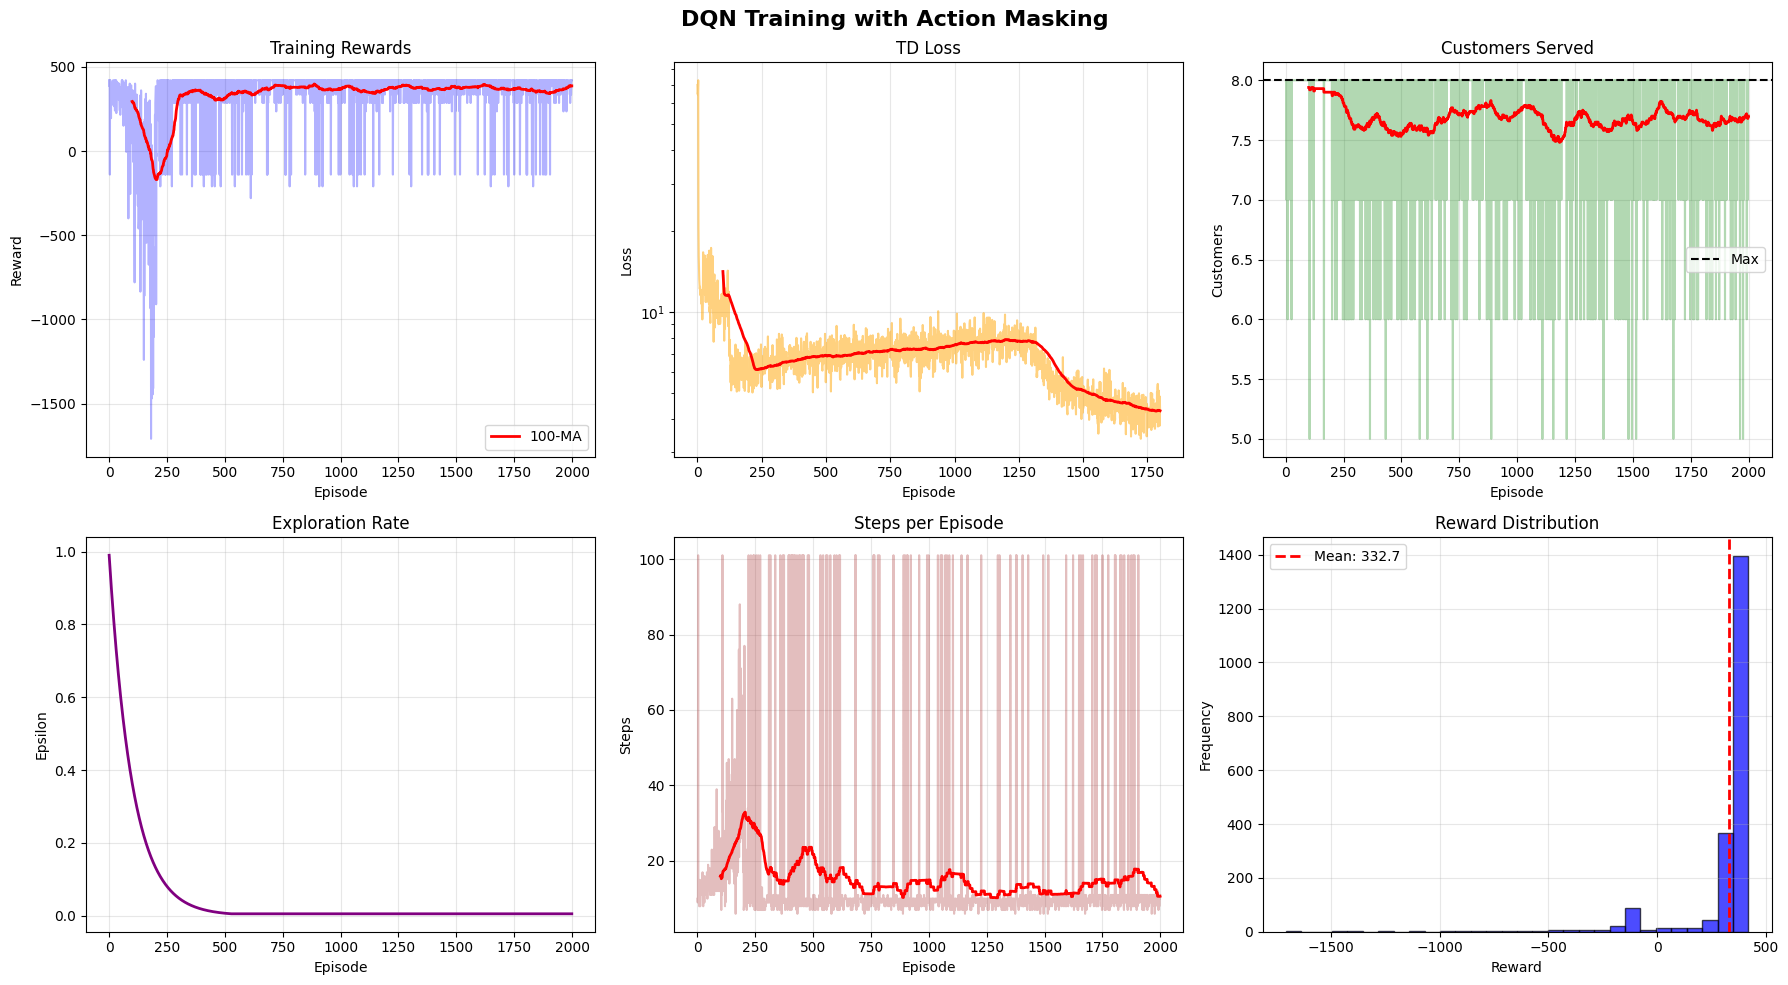


EVALUATION (100 episodes)

Results:
  Reward: 397.4 ± 93.1
  Customers: 7.8/8
  Success Rate: 91%
  Depot Return Rate: 91%
  Avg Charging Stops: 1.6
  Steps: 12.3 ± 12.7

Episode visualization saved to 'single_uav_episode.png'



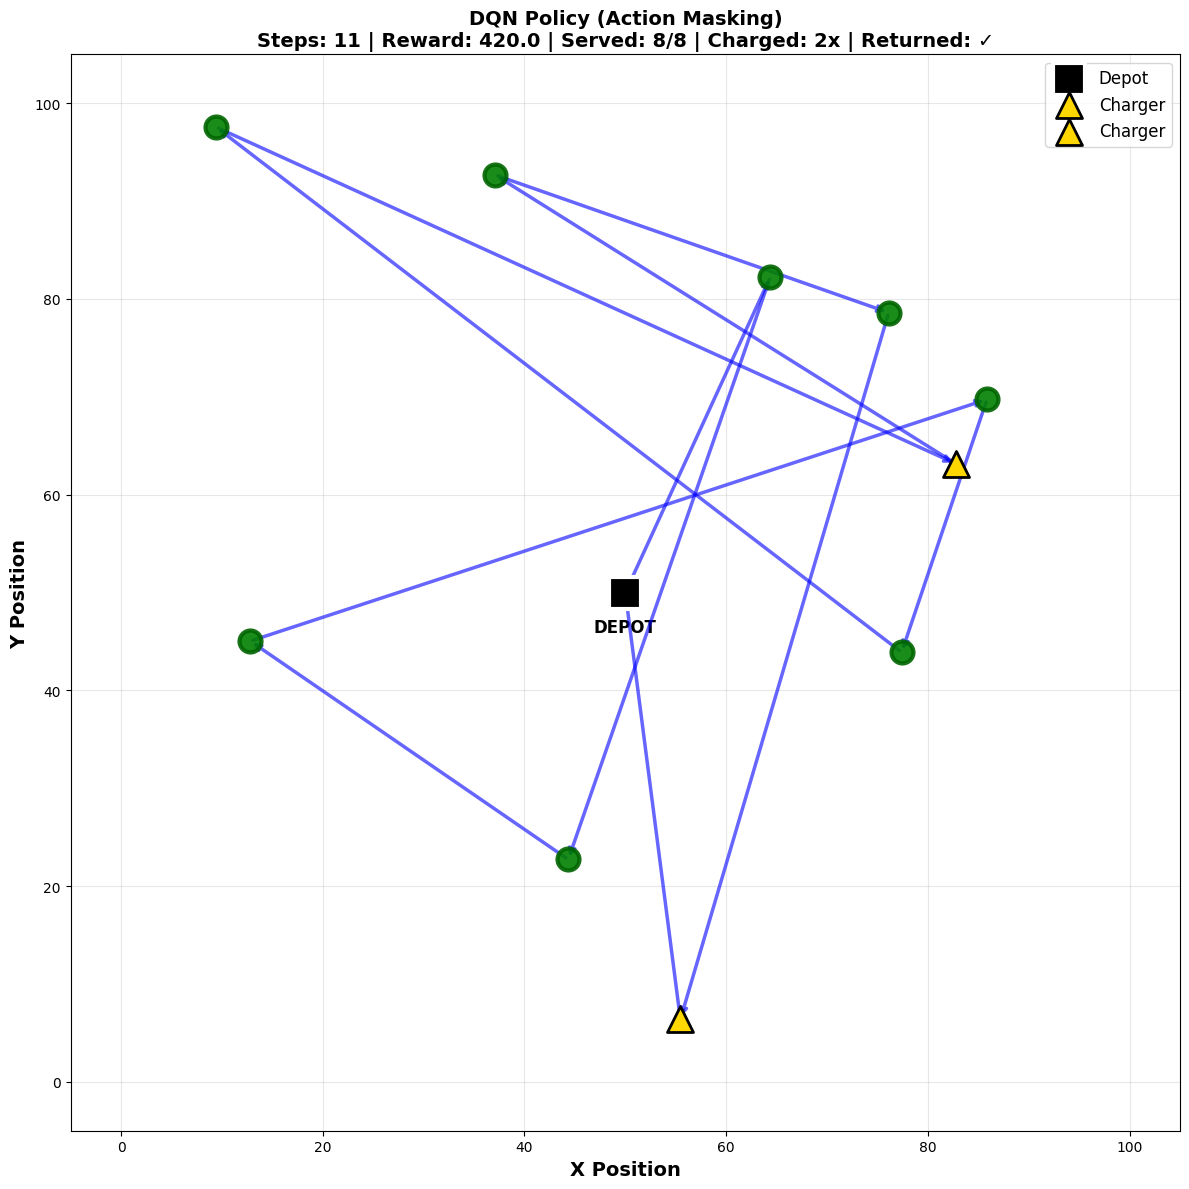

In [ ]:
DQN_AGENT_CONFIG = {
    'learning_rate': 2e-3,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.005,
    'epsilon_decay': 0.990,
    'buffer_size': 150000,
    'batch_size': 512,
    'target_update_freq': 4,
    'polyak_tau': 0.015,
}

ENV_CONFIG = SingleUAVConfig(
    num_customers=8,
    num_chargers=2,
    mission_time=1000.0,
    battery_capacity=250.0,
    battery_per_meter=0.6,
    drone_speed=15.0,
    service_reward=50.0,
    charger_time_cost=1.0,
    recharge_rate=150.0,
    penalty_infeasible=15.0,
    penalty_repeat=5.0,
    penalty_tardiness=0.1,
    deadline_min=150.0,
    deadline_max=600.0,
    max_steps=100,
    deterministic_seed=42,
)

# Create environment and trainer
env = SingleUAVEnv(ENV_CONFIG)
trainer = SingleUAVDQNTrainer(env, DQN_AGENT_CONFIG)

# Train with action masking
trainer.train(num_episodes=2000, log_interval=50, warmup_episodes=200)

# Evaluate and visualize
trainer.plot_training_curves()
trainer.evaluate(num_episodes=100)
trainer.visualize_episode(seed=42)

##Hyperparameter tuning_DQN


HYPERPARAMETER TUNING FOR DQN
Testing 5 batch sizes and 2 network types
Episodes per config: 500, Runs per config: 3

Testing batch sizes...
  Batch size: 64

Trainer Initialization:
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers

TRAINING: 500 episodes (warmup: 50)
Features: Action masking, customer revisit prevention, efficiency rewards


Training Complete!
  Best Reward: 420.0
  Final Avg: 378.5
  Final Customers: 7.8/8


EVALUATION (20 episodes)

Results:
  Reward: 408.0 ± 22.7
  Customers: 8.0/8
  Success Rate: 95%
  Depot Return Rate: 85%
  Avg Charging Stops: 1.1
  Steps: 10.2 ± 1.0


Trainer Initialization:
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers

TRAINING: 500 episodes (warmup: 50)
Features: Action masking, customer revisit prevention, efficiency rewards


Training Complete!
  Best Reward: 420.0
  Final Avg: 363.9
  Final Customers: 7.7/8


EVALUATION (20 episodes)

Results:
  Reward: 367.2 ± 121.

/tmp/ipython-input-488277392.py:249: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1b.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes],
/tmp/ipython-input-488277392.py:298: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2b.boxplot(net_data, labels=labels_net, patch_artist=True, showmeans=True)



 Hyperparameter tuning plots saved to 'dqn_hyperparameter_tuning.png'


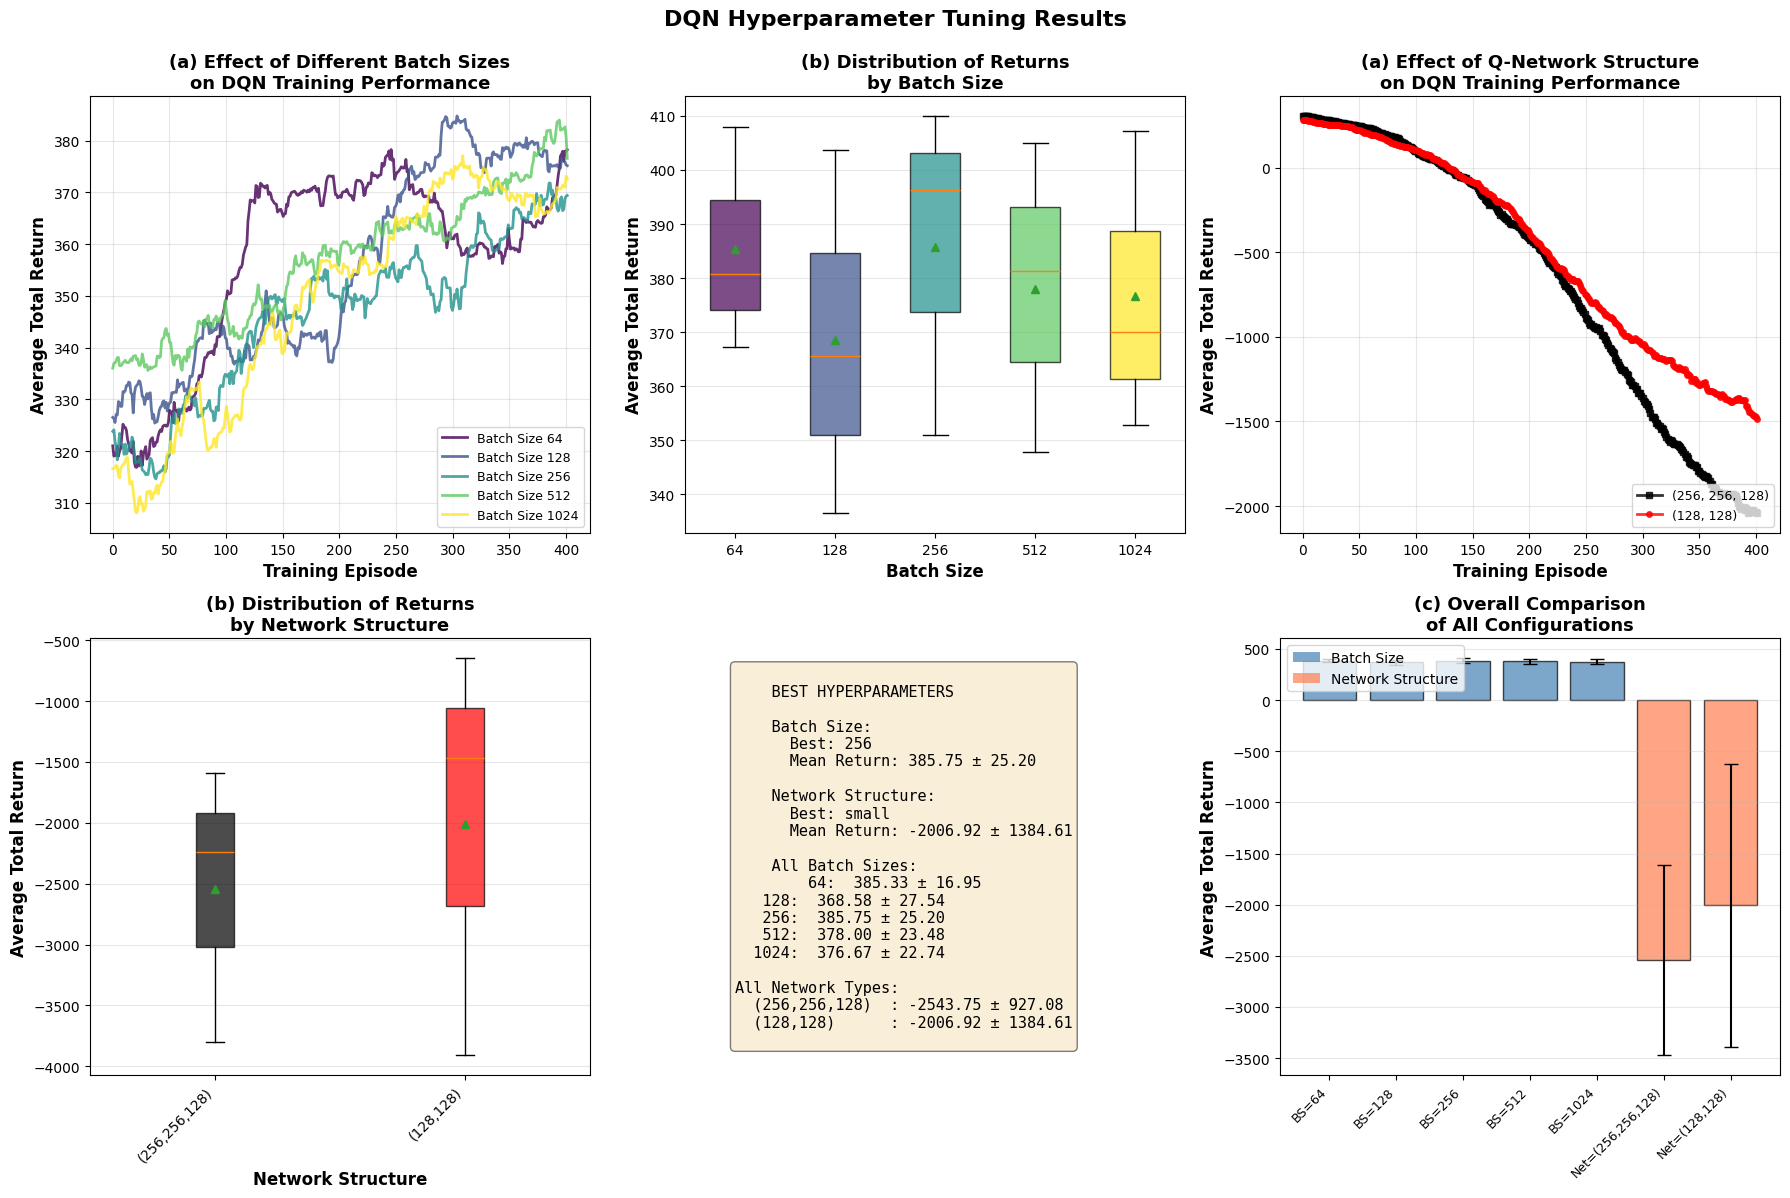


RECOMMENDED CONFIGURATION:
Batch Size: 256
Network: small


In [ ]:
# ============================================================================
# HYPERPARAMETER TUNING SECTION -
# ============================================================================
# This section performs hyperparameter tuning and generates plots showing
# the effect of different batch sizes and network structures on DQN performance

class DQNNetworkVariants:
    """Different network architectures for hyperparameter tuning."""

    @staticmethod
    def create_network(state_dim, action_dim, arch_type='medium'):
        """Create network with specified architecture."""
        if arch_type == 'small':
            return DQNetwork(state_dim, action_dim)  # Default: [128, 128]
        elif arch_type == 'medium':
            return DuelingDQNetwork(state_dim, action_dim)  # [256, 256] + value/advantage
        elif arch_type == 'large':
            # Custom larger network
            class LargeDQN(nn.Module):
                def __init__(self, state_dim, action_dim):
                    super(LargeDQN, self).__init__()
                    self.fc1 = nn.Linear(state_dim, 256)
                    self.fc2 = nn.Linear(256, 256)
                    self.fc3 = nn.Linear(256, 128)
                    self.fc4 = nn.Linear(128, action_dim)
                    for m in self.modules():
                        if isinstance(m, nn.Linear):
                            nn.init.xavier_uniform_(m.weight)
                def forward(self, x):
                    x = F.relu(self.fc1(x))
                    x = F.relu(self.fc2(x))
                    x = F.relu(self.fc3(x))
                    return self.fc4(x)
            return LargeDQN(state_dim, action_dim)
        elif arch_type == 'xlarge':
            # Extra large network
            class XLargeDQN(nn.Module):
                def __init__(self, state_dim, action_dim):
                    super(XLargeDQN, self).__init__()
                    self.fc1 = nn.Linear(state_dim, 512)
                    self.fc2 = nn.Linear(512, 512)
                    self.fc3 = nn.Linear(512, 256)
                    self.fc4 = nn.Linear(256, action_dim)
                    for m in self.modules():
                        if isinstance(m, nn.Linear):
                            nn.init.xavier_uniform_(m.weight)
                def forward(self, x):
                    x = F.relu(self.fc1(x))
                    x = F.relu(self.fc2(x))
                    x = F.relu(self.fc3(x))
                    return self.fc4(x)
            return XLargeDQN(state_dim, action_dim)


def tune_hyperparameters(
    batch_sizes=[64, 128, 256, 512, 1024],
    network_types=['small', 'large'],
    num_episodes=1000,
    num_runs=3
):
    """
    Perform hyperparameter tuning for DQN.

    Args:
        batch_sizes: List of batch sizes to test
        network_types: List of network architectures to test
        num_episodes: Number of training episodes per configuration
        num_runs: Number of independent runs per configuration

    Returns:
        Dictionary with tuning results
    """
    print("="*80)
    print("HYPERPARAMETER TUNING FOR DQN")
    print("="*80)
    print(f"Testing {len(batch_sizes)} batch sizes and {len(network_types)} network types")
    print(f"Episodes per config: {num_episodes}, Runs per config: {num_runs}\n")

    results = {
        'batch_size': {},
        'network_type': {}
    }

    env = SingleUAVEnv(ENV_CONFIG)
    obs, _ = env.reset()
    state_dim = (
        obs['agent'].shape[0] +
        obs['visited'].flatten().shape[0] +
        obs['deadlines'].flatten().shape[0] +
        obs['node_positions'].flatten().shape[0]
    )
    action_dim = env.action_space.n

    # Test batch sizes (using default DQN)
    print("Testing batch sizes...")
    for batch_size in batch_sizes:
        print(f"  Batch size: {batch_size}")
        batch_rewards = []
        batch_curves = []

        for run in range(num_runs):
            config = DQN_AGENT_CONFIG.copy()
            config['batch_size'] = batch_size

            trainer = SingleUAVDQNTrainer(env, config)
            trainer.train(num_episodes=num_episodes, log_interval=num_episodes+1, warmup_episodes=50)

            # Get final performance
            eval_results = trainer.evaluate(num_episodes=20, render=False)
            final_reward = np.mean(eval_results['rewards'])
            batch_rewards.append(final_reward)

            # Store training curve
            if len(trainer.episode_rewards) >= 100:
                ma = np.convolve(trainer.episode_rewards, np.ones(100)/100, mode='valid')
                batch_curves.append(ma)

        results['batch_size'][batch_size] = {
            'rewards': batch_rewards,
            'mean': np.mean(batch_rewards),
            'std': np.std(batch_rewards),
            'curves': batch_curves
        }
        print(f"    Mean reward: {np.mean(batch_rewards):.2f} ± {np.std(batch_rewards):.2f}")

    # Test network types (using default batch size)
    print("\nTesting network architectures...")

    # Define network architectures
    class LargeDQN(nn.Module):
        """Large DQN: (256, 256, 128)"""
        def __init__(self, state_dim, action_dim):
            super(LargeDQN, self).__init__()
            self.fc1 = nn.Linear(state_dim, 256)
            self.fc2 = nn.Linear(256, 256)
            self.fc3 = nn.Linear(256, 128)
            self.fc4 = nn.Linear(128, action_dim)
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            return self.fc4(x)

    class XLargeDQN(nn.Module):
        """Extra Large DQN: (512, 512, 256)"""
        def __init__(self, state_dim, action_dim):
            super(XLargeDQN, self).__init__()
            self.fc1 = nn.Linear(state_dim, 512)
            self.fc2 = nn.Linear(512, 512)
            self.fc3 = nn.Linear(512, 256)
            self.fc4 = nn.Linear(256, action_dim)
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            return self.fc4(x)

    for net_type in network_types:
        print(f"  Network type: {net_type}")
        net_rewards = []
        net_curves = []

        for run in range(num_runs):
            # Create custom agent with specified network
            config = DQN_AGENT_CONFIG.copy()
            trainer = SingleUAVDQNTrainer(env, config)

            # Replace network with variant
            if net_type == 'small':
                trainer.agent.policy_net = DQNetwork(state_dim, action_dim)
                trainer.agent.target_net = DQNetwork(state_dim, action_dim)
            elif net_type == 'large':
                trainer.agent.policy_net = LargeDQN(state_dim, action_dim)
                trainer.agent.target_net = LargeDQN(state_dim, action_dim)
            elif net_type == 'xlarge':
                trainer.agent.policy_net = XLargeDQN(state_dim, action_dim)
                trainer.agent.target_net = XLargeDQN(state_dim, action_dim)

            trainer.agent.target_net.load_state_dict(trainer.agent.policy_net.state_dict())
            trainer.agent.target_net.eval()

            trainer.train(num_episodes=num_episodes, log_interval=num_episodes+1, warmup_episodes=50)

            eval_results = trainer.evaluate(num_episodes=20, render=False)
            final_reward = np.mean(eval_results['rewards'])
            net_rewards.append(final_reward)

            if len(trainer.episode_rewards) >= 100:
                ma = np.convolve(trainer.episode_rewards, np.ones(100)/100, mode='valid')
                net_curves.append(ma)

        results['network_type'][net_type] = {
            'rewards': net_rewards,
            'mean': np.mean(net_rewards),
            'std': np.std(net_rewards),
            'curves': net_curves
        }
        print(f"    Mean reward: {np.mean(net_rewards):.2f} ± {np.std(net_rewards):.2f}")

    print("\n" + "="*80)
    print("TUNING COMPLETE")
    print("="*80)

    return results


def plot_hyperparameter_tuning_results(results):
    """
    Generate plots similar to DDPG tuning figures.

    Creates:
    - Figure A1: Effect of batch sizes (training curves + box plots)
    - Figure A2: Effect of network structures (training curves)
    """
    fig = plt.figure(figsize=(18, 12))

    # ========== Figure A1: Batch Size Effects ==========
    # A1(a): Training curves for different batch sizes
    ax1a = plt.subplot(2, 3, 1)
    batch_sizes = sorted(results['batch_size'].keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))

    for i, bs in enumerate(batch_sizes):
        curves = results['batch_size'][bs]['curves']
        if curves:
            # Average across runs
            avg_curve = np.mean([c for c in curves if len(c) > 0], axis=0) if curves else []
            if len(avg_curve) > 0:
                epochs = np.linspace(0, len(avg_curve), len(avg_curve))
                ax1a.plot(epochs, avg_curve, label=f'Batch Size {bs}',
                         color=colors[i], linewidth=2, alpha=0.8)

    ax1a.set_xlabel('Training Episode', fontsize=12, fontweight='bold')
    ax1a.set_ylabel('Average Total Return', fontsize=12, fontweight='bold')
    ax1a.set_title('(a) Effect of Different Batch Sizes\non DQN Training Performance',
                   fontsize=13, fontweight='bold')
    ax1a.legend(loc='lower right', fontsize=9)
    ax1a.grid(True, alpha=0.3)

    # A1(b): Box plot for batch sizes
    ax1b = plt.subplot(2, 3, 2)
    batch_data = [results['batch_size'][bs]['rewards'] for bs in batch_sizes]
    bp1 = ax1b.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes],
                       patch_artist=True, showmeans=True)

    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax1b.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    ax1b.set_ylabel('Average Total Return', fontsize=12, fontweight='bold')
    ax1b.set_title('(b) Distribution of Returns\nby Batch Size',
                   fontsize=13, fontweight='bold')
    ax1b.grid(True, alpha=0.3, axis='y')

    # ========== Figure A2: Network Structure Effects ==========
    # A2(a): Actor/Critic network structure (for DQN, this is the Q-network)
    ax2a = plt.subplot(2, 3, 3)
    net_types = sorted(results['network_type'].keys())
    markers = ['s', 'o', '^', 'D']
    colors_net = ['black', 'red', 'blue', 'green']

    for i, net_type in enumerate(net_types):
        curves = results['network_type'][net_type]['curves']
        if curves:
            avg_curve = np.mean([c for c in curves if len(c) > 0], axis=0) if curves else []
            if len(avg_curve) > 0:
                epochs = np.linspace(0, len(avg_curve), len(avg_curve))
                label_map = {
                    'small': '(128, 128)',
                    'large': '(256, 256, 128)',
                    'xlarge': '(512, 512, 256)'
                }
                ax2a.plot(epochs, avg_curve, label=label_map.get(net_type, net_type),
                         color=colors_net[i % len(colors_net)],
                         marker=markers[i % len(markers)],
                         linewidth=2, markersize=4, alpha=0.8)

    ax2a.set_xlabel('Training Episode', fontsize=12, fontweight='bold')
    ax2a.set_ylabel('Average Total Return', fontsize=12, fontweight='bold')
    ax2a.set_title('(a) Effect of Q-Network Structure\non DQN Training Performance',
                   fontsize=13, fontweight='bold')
    ax2a.legend(loc='lower right', fontsize=9)
    ax2a.grid(True, alpha=0.3)

    # A2(b): Box plot for network types
    ax2b = plt.subplot(2, 3, 4)
    net_data = [results['network_type'][nt]['rewards'] for nt in net_types]
    labels_net = [{'small': '(128,128)',
                   'large': '(256,256,128)', 'xlarge': '(512,512,256)'}.get(nt, nt)
                  for nt in net_types]
    bp2 = ax2b.boxplot(net_data, labels=labels_net, patch_artist=True, showmeans=True)

    for patch, color in zip(bp2['boxes'], colors_net[:len(net_types)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2b.set_xlabel('Network Structure', fontsize=12, fontweight='bold')
    ax2b.set_ylabel('Average Total Return', fontsize=12, fontweight='bold')
    ax2b.set_title('(b) Distribution of Returns\nby Network Structure',
                   fontsize=13, fontweight='bold')
    ax2b.grid(True, alpha=0.3, axis='y')
    plt.setp(ax2b.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # ========== Summary: Best Parameters ==========
    ax_sum = plt.subplot(2, 3, 5)
    ax_sum.axis('off')

    # Find best batch size
    best_batch = max(results['batch_size'].items(), key=lambda x: x[1]['mean'])
    best_net = max(results['network_type'].items(), key=lambda x: x[1]['mean'])

    summary_text = f"""
    BEST HYPERPARAMETERS

    Batch Size:
      Best: {best_batch[0]}
      Mean Return: {best_batch[1]['mean']:.2f} ± {best_batch[1]['std']:.2f}

    Network Structure:
      Best: {best_net[0]}
      Mean Return: {best_net[1]['mean']:.2f} ± {best_net[1]['std']:.2f}

    All Batch Sizes:
    """
    for bs in sorted(results['batch_size'].keys()):
        r = results['batch_size'][bs]
        summary_text += f"  {bs:4d}: {r['mean']:7.2f} ± {r['std']:.2f}\n"

    summary_text += "\nAll Network Types:\n"
    for nt in sorted(results['network_type'].keys()):
        r = results['network_type'][nt]
        label = {'small': '(128,128)',
                 'large': '(256,256,128)', 'xlarge': '(512,512,256)'}.get(nt, nt)
        summary_text += f"  {label:15s}: {r['mean']:7.2f} ± {r['std']:.2f}\n"

    ax_sum.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round',
                facecolor='wheat', alpha=0.5))

    # ========== Comparison Plot ==========
    ax_comp = plt.subplot(2, 3, 6)

    # Combine batch size and network results for comparison
    all_configs = []
    all_means = []
    all_stds = []
    all_labels = []

    for bs in sorted(results['batch_size'].keys()):
        r = results['batch_size'][bs]
        all_configs.append(f'BS={bs}')
        all_means.append(r['mean'])
        all_stds.append(r['std'])
        all_labels.append('Batch Size')

    for nt in sorted(results['network_type'].keys()):
        r = results['network_type'][nt]
        label = {'small': '(128,128)',
                 'large': '(256,256,128)', 'xlarge': '(512,512,256)'}.get(nt, nt)
        all_configs.append(f'Net={label}')
        all_means.append(r['mean'])
        all_stds.append(r['std'])
        all_labels.append('Network')

    x_pos = np.arange(len(all_configs))
    colors_comp = ['steelblue' if l == 'Batch Size' else 'coral' for l in all_labels]

    bars = ax_comp.bar(x_pos, all_means, yerr=all_stds, capsize=5,
                       color=colors_comp, alpha=0.7, edgecolor='black')
    ax_comp.set_xticks(x_pos)
    ax_comp.set_xticklabels(all_configs, rotation=45, ha='right', fontsize=9)
    ax_comp.set_ylabel('Average Total Return', fontsize=12, fontweight='bold')
    ax_comp.set_title('(c) Overall Comparison\nof All Configurations',
                     fontsize=13, fontweight='bold')
    ax_comp.grid(True, alpha=0.3, axis='y')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', alpha=0.7, label='Batch Size'),
        Patch(facecolor='coral', alpha=0.7, label='Network Structure')
    ]
    ax_comp.legend(handles=legend_elements, loc='upper left')

    plt.suptitle('DQN Hyperparameter Tuning Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('dqn_hyperparameter_tuning.png', dpi=150, bbox_inches='tight')
    print("\n Hyperparameter tuning plots saved to 'dqn_hyperparameter_tuning.png'")
    plt.show()

    return best_batch, best_net


# ============================================================================
# RUN HYPERPARAMETER TUNING (Uncomment to run)
# ============================================================================
# NOTE: This will take significant time. Adjust num_episodes and num_runs for faster testing.
#
tuning_results = tune_hyperparameters(
     batch_sizes=[64, 128, 256, 512, 1024],
     network_types=['small', 'large'],
     num_episodes=500,  # Reduced for faster testing
     num_runs=3)
#
best_batch, best_net = plot_hyperparameter_tuning_results(tuning_results)
#
print("\n" + "="*80)
print("RECOMMENDED CONFIGURATION:")
print("="*80)
print(f"Batch Size: {best_batch[0]}")
print(f"Network: {best_net[0]}")
print("="*80)

# DDQN + Different Reward functions

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import random
from typing import Dict, Callable
import matplotlib.pyplot as plt

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])


class ReplayBuffer:
    """Experience replay buffer for DDQN."""
    def __init__(self, capacity: int = 20000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


class DDQNetwork(nn.Module):
    """Deep Q-Network for DDQN with optional dueling architecture."""
    def __init__(self, state_dim: int, action_dim: int, dueling: bool = False):
        super(DDQNetwork, self).__init__()
        self.dueling = dueling

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)

        if dueling:
            # Dueling architecture: separate value and advantage streams
            self.value_fc = nn.Linear(256, 128)
            self.value_out = nn.Linear(128, 1)
            self.advantage_fc = nn.Linear(256, 128)
            self.advantage_out = nn.Linear(128, action_dim)
        else:
            # Standard architecture
            self.fc3 = nn.Linear(256, action_dim)

        # Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        if self.dueling:
            # Dueling DQN: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
            value = F.relu(self.value_fc(x))
            value = self.value_out(value)

            advantage = F.relu(self.advantage_fc(x))
            advantage = self.advantage_out(advantage)

            # Combine value and advantage
            q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
            return q_values
        else:
            return self.fc3(x)


# ========================================
# REWARD SHAPING FUNCTIONS
# ========================================

class RewardShaper:
    """Base class for reward shaping strategies."""

    def __init__(self, env):
        self.env = env
        self.name = "Base"

    def shape_reward(self, obs: dict, action: int, reward: float,
                    next_obs: dict, done: bool, info: dict,
                    prev_visited: int, episode_steps: int) -> float:
        """Override this method to implement custom reward shaping."""
        return reward


class LinearWeightedReward(RewardShaper):
    """Linear weighted combination of multiple reward components."""

    def __init__(self, env, weights: dict = None):
        super().__init__(env)
        self.name = "LinearWeighted"

        # Default weights
        default_weights = {
            'new_customer': 50.0,
            'completion_bonus': 200.0,
            'completion_no_return': 100.0,
            'return_penalty': 50.0,
            'incomplete_per_customer': 80.0,
            'early_quit_penalty': 100.0,
            'progress_bonus': 20.0,
            'time_efficiency_bonus': 100.0,
        }
        self.weights = {**default_weights, **(weights or {})}

    def shape_reward(self, obs, action, reward, next_obs, done, info,
                    prev_visited, episode_steps):
        shaped_reward = reward
        current_visited = np.sum(next_obs['visited'])

        # New customer served
        if current_visited > prev_visited:
            shaped_reward += self.weights['new_customer']

        # End-of-episode rewards
        if done:
            total_customers = self.env.config.num_customers

            if current_visited == total_customers:
                # Mission complete!
                if info.get('returned_to_depot', False):
                    shaped_reward += self.weights['completion_bonus']
                    time_efficiency = next_obs['agent'][2]
                    shaped_reward += time_efficiency * self.weights['time_efficiency_bonus']
                else:
                    shaped_reward += self.weights['completion_no_return']
                    shaped_reward -= self.weights['return_penalty']
            else:
                # Incomplete mission
                missing = total_customers - current_visited
                shaped_reward -= missing * self.weights['incomplete_per_customer']

                if current_visited <= total_customers * 0.6:
                    shaped_reward -= self.weights['early_quit_penalty']

        # Progressive encouragement
        progress_ratio = current_visited / self.env.config.num_customers
        if current_visited > prev_visited:
            shaped_reward += self.weights['progress_bonus'] * (1.0 + progress_ratio)

        return shaped_reward


class NonLinearExponentialReward(RewardShaper):
    """Non-linear exponential reward that increases dramatically with progress."""

    def __init__(self, env, base_multiplier: float = 2.0, exp_factor: float = 1.5):
        super().__init__(env)
        self.name = "NonLinearExponential"
        self.base_multiplier = base_multiplier
        self.exp_factor = exp_factor

    def shape_reward(self, obs, action, reward, next_obs, done, info,
                    prev_visited, episode_steps):
        shaped_reward = reward
        current_visited = np.sum(next_obs['visited'])
        total_customers = self.env.config.num_customers
        progress_ratio = current_visited / total_customers

        # Exponentially increasing reward for each new customer
        if current_visited > prev_visited:
            # r = base * exp(progress^exp_factor)
            exponential_bonus = self.base_multiplier * 30.0 * np.exp(
                self.exp_factor * progress_ratio
            )
            shaped_reward += exponential_bonus

        # End rewards with exponential scaling
        if done:
            if current_visited == total_customers:
                completion_bonus = 150.0 * np.exp(self.exp_factor)

                if info.get('returned_to_depot', False):
                    shaped_reward += completion_bonus
                    time_eff = next_obs['agent'][2]
                    shaped_reward += 100.0 * (time_eff ** 2)  # Quadratic time bonus
                else:
                    shaped_reward += completion_bonus * 0.6
                    shaped_reward -= 80.0
            else:
                # Exponential penalty for incompletion
                incompletion_ratio = 1.0 - progress_ratio
                shaped_reward -= 50.0 * np.exp(2.0 * incompletion_ratio)

        return shaped_reward


class NonLinearSigmoidReward(RewardShaper):
    """Sigmoid-based reward that provides smooth transitions between states."""

    def __init__(self, env, steepness: float = 10.0, midpoint: float = 0.5):
        super().__init__(env)
        self.name = "NonLinearSigmoid"
        self.steepness = steepness
        self.midpoint = midpoint

    def _sigmoid(self, x, k=10, x0=0.5):
        """Sigmoid function: 1 / (1 + exp(-k(x - x0)))"""
        return 1.0 / (1.0 + np.exp(-k * (x - x0)))

    def shape_reward(self, obs, action, reward, next_obs, done, info,
                    prev_visited, episode_steps):
        shaped_reward = reward
        current_visited = np.sum(next_obs['visited'])
        total_customers = self.env.config.num_customers
        progress_ratio = current_visited / total_customers

        # Sigmoid-scaled reward for new customers
        if current_visited > prev_visited:
            sigmoid_multiplier = self._sigmoid(
                progress_ratio, self.steepness, self.midpoint
            )
            shaped_reward += 80.0 * sigmoid_multiplier

        # End rewards
        if done:
            if current_visited == total_customers:
                sigmoid_bonus = 200.0 * self._sigmoid(1.0, self.steepness, self.midpoint)

                if info.get('returned_to_depot', False):
                    shaped_reward += sigmoid_bonus
                    time_eff = next_obs['agent'][2]
                    shaped_reward += 100.0 * self._sigmoid(time_eff, 5, 0.3)
                else:
                    shaped_reward += sigmoid_bonus * 0.5
            else:
                # Inverse sigmoid penalty for incompletion
                penalty_multiplier = 1.0 - self._sigmoid(
                    progress_ratio, self.steepness, self.midpoint
                )
                shaped_reward -= 150.0 * penalty_multiplier

        return shaped_reward


class AdaptiveDynamicReward(RewardShaper):
    """Adaptive reward that changes behavior based on training progress."""

    def __init__(self, env, episode_count_ref: list):
        super().__init__(env)
        self.name = "AdaptiveDynamic"
        self.episode_count_ref = episode_count_ref  # Reference to trainer's episode count

    def shape_reward(self, obs, action, reward, next_obs, done, info,
                    prev_visited, episode_steps):
        shaped_reward = reward
        current_visited = np.sum(next_obs['visited'])
        total_customers = self.env.config.num_customers

        # Get current training phase (0.0 = start, 1.0 = end)
        episode = self.episode_count_ref[0] if self.episode_count_ref else 0
        training_progress = min(1.0, episode / 2000.0)  # Normalize to [0, 1]

        # Early training: focus on exploration and any customer service
        # Late training: focus on efficiency and completion

        if current_visited > prev_visited:
            # Start with high rewards, gradually reduce as agent learns
            exploration_bonus = 60.0 * (1.0 - 0.5 * training_progress)
            shaped_reward += exploration_bonus

        if done:
            if current_visited == total_customers:
                # Increase completion bonus as training progresses
                completion_weight = 150.0 + 100.0 * training_progress

                if info.get('returned_to_depot', False):
                    shaped_reward += completion_weight

                    # Time efficiency becomes more important later
                    time_eff = next_obs['agent'][2]
                    efficiency_weight = 50.0 + 100.0 * training_progress
                    shaped_reward += time_eff * efficiency_weight
                else:
                    shaped_reward += completion_weight * 0.6
                    # Penalize non-return more as training progresses
                    shaped_reward -= 30.0 * (1.0 + training_progress)
            else:
                # Incomplete penalty increases with training progress
                missing = total_customers - current_visited
                base_penalty = 60.0 + 40.0 * training_progress
                shaped_reward -= missing * base_penalty

        return shaped_reward


class SparseMissionReward(RewardShaper):
    """Sparse reward: only reward at mission completion."""

    def __init__(self, env):
        super().__init__(env)
        self.name = "SparseMission"

    def shape_reward(self, obs, action, reward, next_obs, done, info,
                    prev_visited, episode_steps):
        # Ignore intermediate rewards, only reward at end
        if not done:
            return -0.1  # Small step penalty to encourage efficiency

        current_visited = np.sum(next_obs['visited'])
        total_customers = self.env.config.num_customers

        if current_visited == total_customers:
            if info.get('returned_to_depot', False):
                return 300.0  # Large reward for perfect completion
            else:
                return 150.0  # Partial reward for completion without return
        else:
            # Penalty proportional to incompleteness
            completion_ratio = current_visited / total_customers
            return -100.0 * (1.0 - completion_ratio)


# ========================================
# DDQN AGENT
# ========================================

class SingleUAVDDQNAgent:
    """Double DQN agent with action masking and flexible reward shaping."""

    def __init__(
        self,
        env,
        state_dim: int,
        action_dim: int,
        learning_rate: float = 1e-4,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.1,
        epsilon_decay: float = 0.998,
        buffer_size: int = 20000,
        batch_size: int = 128,
        target_update_freq: int = 200,
        polyak_tau: float = 0.005,
        dueling: bool = False,
        reward_shaper: RewardShaper = None,
    ):
        self.env = env
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.polyak_tau = polyak_tau

        # Reward shaping
        self.reward_shaper = reward_shaper or LinearWeightedReward(env)

        # Networks
        self.policy_net = DDQNetwork(state_dim, action_dim, dueling=dueling)
        self.target_net = DDQNetwork(state_dim, action_dim, dueling=dueling)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.update_counter = 0

    def flatten_obs(self, obs: dict) -> np.ndarray:
        """Flatten dictionary observation to vector."""
        return np.concatenate([
            obs['agent'],
            obs['visited'].flatten(),
            obs['deadlines'].flatten(),
            obs['node_positions'].flatten(),
        ])

    def get_action_mask(self, obs: dict) -> np.ndarray:
        """Create feasible action mask."""
        mask = np.ones(self.action_dim, dtype=bool)

        current_node = self.env.current_node
        visited = obs['visited']
        battery = obs['agent'][1] * self.env.config.battery_capacity
        time_left = obs['agent'][2] * self.env.config.mission_time

        for action in range(self.action_dim):
            if action == current_node:
                mask[action] = False
                continue

            if self._is_customer(action) and visited[action - 1] == 1:
                mask[action] = False
                continue

            distance = self.env._distance(current_node, action)
            energy_needed = distance * self.env.config.battery_per_meter
            time_needed = distance / self.env.config.drone_speed

            if energy_needed > battery or time_needed > time_left:
                mask[action] = False

        if not mask.any():
            mask[0] = True

        return mask

    def _is_customer(self, node_id: int) -> bool:
        return 1 <= node_id < 1 + self.env.config.num_customers

    def select_action(self, obs: dict, training: bool = True) -> int:
        """Select action with action masking."""
        state = self.flatten_obs(obs)
        action_mask = self.get_action_mask(obs)
        valid_actions = np.where(action_mask)[0]

        if training and random.random() < self.epsilon:
            visited = obs['visited']
            unvisited_customers = [a for a in valid_actions
                                  if self._is_customer(a) and visited[a-1] == 0]

            if unvisited_customers and random.random() < 0.8:
                return random.choice(unvisited_customers)
            else:
                return random.choice(valid_actions)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_net(state_tensor).squeeze().numpy()
            q_values[~action_mask] = -np.inf
            return int(np.argmax(q_values))

    def store_transition(self, obs, action, reward, next_obs, done):
        """Store transition in replay buffer."""
        state = self.flatten_obs(obs)
        next_state = self.flatten_obs(next_obs)
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self) -> float:
        """
        DDQN Update Rule (KEY DIFFERENCE FROM DQN):
        - Use policy_net to SELECT the best action
        - Use target_net to EVALUATE that action's Q-value
        This reduces overestimation bias.
        """
        if len(self.replay_buffer) < self.batch_size:
            return 0.0

        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.FloatTensor(np.array(batch.state))
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state))
        done_batch = torch.FloatTensor(batch.done)

        # Current Q-values
        current_q = self.policy_net(state_batch).gather(1, action_batch).squeeze()

        with torch.no_grad():
            # DDQN: Select action with policy_net
            next_actions = self.policy_net(next_state_batch).argmax(1, keepdim=True)

            # DDQN: Evaluate action with target_net
            next_q = self.target_net(next_state_batch).gather(1, next_actions).squeeze()

            target_q = reward_batch + (1 - done_batch) * self.gamma * next_q
            target_q = torch.clamp(target_q, -300, 300)

        loss = F.smooth_l1_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()

        # Soft target update
        self.update_counter += 1
        for target_param, policy_param in zip(self.target_net.parameters(),
                                               self.policy_net.parameters()):
            target_param.data.copy_(
                self.polyak_tau * policy_param.data +
                (1 - self.polyak_tau) * target_param.data
            )

        # Periodic hard update
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# ========================================
# DDQN TRAINER
# ========================================

class SingleUAVDDQNTrainer:
    """Trainer for DDQN with flexible reward shaping."""

    def __init__(self, env, config: dict = None, reward_shaper: RewardShaper = None):
        self.env = env

        obs, _ = env.reset()
        self.state_dim = (
            obs['agent'].shape[0] +
            obs['visited'].flatten().shape[0] +
            obs['deadlines'].flatten().shape[0] +
            obs['node_positions'].flatten().shape[0]
        )
        self.action_dim = env.action_space.n

        default_config = {
            'learning_rate': 1e-4,
            'gamma': 0.99,
            'epsilon_start': 1.0,
            'epsilon_end': 0.1,
            'epsilon_decay': 0.998,
            'buffer_size': 20000,
            'batch_size': 128,
            'target_update_freq': 200,
            'polyak_tau': 0.005,
            'dueling': False,
        }
        self.config = {**default_config, **(config or {})}

        # For adaptive reward shaper
        self.episode_counter = [0]

        # Default reward shaper
        if reward_shaper is None:
            reward_shaper = LinearWeightedReward(env)
        elif isinstance(reward_shaper, type):
            # If a class is passed, instantiate it
            if reward_shaper == AdaptiveDynamicReward:
                reward_shaper = reward_shaper(env, self.episode_counter)
            else:
                reward_shaper = reward_shaper(env)

        print(f"\n{'='*80}")
        print(f"DDQN Trainer Initialization")
        print(f"{'='*80}")
        print(f"  State dimension: {self.state_dim}")
        print(f"  Action dimension: {self.action_dim}")
        print(f"  Environment: {env.config.num_customers} customers, {env.config.num_chargers} chargers")
        print(f"  Reward Shaper: {reward_shaper.name}")
        print(f"  Dueling Network: {self.config['dueling']}")
        print(f"{'='*80}\n")

        self.agent = SingleUAVDDQNAgent(
            env, self.state_dim, self.action_dim,
            reward_shaper=reward_shaper,
            **self.config
        )

        # Metrics
        self.episode_rewards = []
        self.episode_losses = []
        self.episode_customers_served = []
        self.episode_steps = []
        self.epsilon_history = []

    def train(self, num_episodes: int = 2000, log_interval: int = 50, warmup_episodes: int = 200):
        """Train DDQN agent."""
        print(f"{'='*80}")
        print(f"TRAINING: {num_episodes} episodes (warmup: {warmup_episodes})")
        print(f"{'='*80}")
        print(f"Algorithm: Double DQN")
        print(f"Features: Action masking, {self.agent.reward_shaper.name} rewards")
        print(f"{'='*80}\n")

        best_reward = float('-inf')

        for episode in range(num_episodes):
            self.episode_counter[0] = episode

            obs, _ = self.env.reset()
            episode_reward = 0
            raw_episode_reward = 0
            episode_loss = []
            done = False
            steps = 0
            prev_visited = 0

            while not done:
                action = self.agent.select_action(obs, training=True)
                next_obs, raw_reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                current_visited = np.sum(next_obs['visited'])

                # Apply reward shaping
                shaped_reward = self.agent.reward_shaper.shape_reward(
                    obs, action, raw_reward, next_obs, done, info, prev_visited, steps
                )

                prev_visited = current_visited

                self.agent.store_transition(obs, action, shaped_reward, next_obs, done)

                if episode >= warmup_episodes:
                    loss = self.agent.update()
                    if loss > 0:
                        episode_loss.append(loss)

                obs = next_obs
                episode_reward += shaped_reward
                raw_episode_reward += raw_reward
                steps += 1

            self.agent.decay_epsilon()

            # Track metrics
            self.episode_rewards.append(episode_reward)
            self.episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
            self.episode_customers_served.append(current_visited)
            self.episode_steps.append(steps)
            self.epsilon_history.append(self.agent.epsilon)

            best_reward = max(best_reward, episode_reward)

            # Logging
            if (episode + 1) % log_interval == 0:
                recent_avg = np.mean(self.episode_rewards[-log_interval:])
                recent_customers = np.mean(self.episode_customers_served[-log_interval:])
                recent_loss = np.mean([l for l in self.episode_losses[-log_interval:] if l > 0])
                recent_steps = np.mean(self.episode_steps[-log_interval:])

                status = "WARMUP" if episode < warmup_episodes else "TRAINING"

                print(f"[{status}] Ep {episode+1:4d}/{num_episodes} | "
                      f"R: {recent_avg:6.1f} | "
                      f"Loss: {recent_loss:5.2f} | "
                      f"Cust: {recent_customers:.1f}/{self.env.config.num_customers} | "
                      f"Steps: {recent_steps:.1f} | "
                      f"ε: {self.agent.epsilon:.3f}")

        print(f"\n{'='*80}")
        print("Training Complete!")
        print(f"  Best Reward: {best_reward:.1f}")
        print(f"  Final Avg (last 100): {np.mean(self.episode_rewards[-100:]):.1f}")
        print(f"  Final Customers: {np.mean(self.episode_customers_served[-100:]):.1f}/{self.env.config.num_customers}")
        print(f"{'='*80}\n")

        return self.episode_rewards

    def evaluate(self, num_episodes: int = 100, render: bool = False):
        """Evaluate the trained agent."""
        print(f"\n{'='*80}")
        print(f"EVALUATION ({num_episodes} episodes)")
        print(f"{'='*80}\n")

        eval_rewards = []
        eval_customers_served = []
        eval_steps = []
        eval_returned = []
        eval_charged = []

        for ep in range(num_episodes):
            obs, _ = self.env.reset()
            episode_reward = 0
            done = False
            steps = 0
            charged_count = 0

            while not done:
                action = self.agent.select_action(obs, training=False)
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                if self.env._is_charger_node(action):
                    charged_count += 1

                if render and ep == 0:
                    self.env.render()

                obs = next_obs
                episode_reward += reward
                steps += 1

            eval_rewards.append(episode_reward)
            eval_customers_served.append(np.sum(obs['visited']))
            eval_steps.append(steps)
            eval_returned.append(1 if info.get('returned_to_depot', False) else 0)
            eval_charged.append(charged_count)

        print(f"Results:")
        print(f"  Reward: {np.mean(eval_rewards):.1f} ± {np.std(eval_rewards):.1f}")
        print(f"  Customers: {np.mean(eval_customers_served):.1f}/{self.env.config.num_customers}")
        print(f"  Success Rate: {np.sum(np.array(eval_customers_served)==self.env.config.num_customers)/num_episodes*100:.0f}%")
        print(f"  Depot Return Rate: {np.mean(eval_returned)*100:.0f}%")
        print(f"  Avg Charging Stops: {np.mean(eval_charged):.1f}")
        print(f"  Steps: {np.mean(eval_steps):.1f} ± {np.std(eval_steps):.1f}")
        print(f"{'='*80}\n")

        return {
            'rewards': eval_rewards,
            'customers_served': eval_customers_served,
            'steps': eval_steps,
            'returned': eval_returned,
            'charged': eval_charged,
        }

    def plot_training_curves(self, save_path: str = 'ddqn_training_curves.png'):
        """Plot comprehensive training curves."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # 1. Rewards
        axes[0, 0].plot(self.episode_rewards, alpha=0.3, color='blue')
        window = 100
        if len(self.episode_rewards) >= window:
            ma = np.convolve(self.episode_rewards, np.ones(window)/window, mode='valid')
            axes[0, 0].plot(range(window-1, len(self.episode_rewards)), ma,
                          color='red', linewidth=2, label=f'{window}-MA')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].set_title('Training Rewards')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        # 2. Loss
        valid_losses = [l for l in self.episode_losses if l > 0]
        if valid_losses:
            axes[0, 1].plot(valid_losses, alpha=0.5, color='orange')
            if len(valid_losses) >= 100:
                ma = np.convolve(valid_losses, np.ones(100)/100, mode='valid')
                axes[0, 1].plot(range(99, len(valid_losses)), ma, color='red', linewidth=2)
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].set_title('TD Loss')
            axes[0, 1].grid(alpha=0.3)
            axes[0, 1].set_yscale('log')

        # 3. Customers
        axes[0, 2].plot(self.episode_customers_served, alpha=0.3, color='green')
        if len(self.episode_customers_served) >= 100:
            ma = np.convolve(self.episode_customers_served, np.ones(100)/100, mode='valid')
            axes[0, 2].plot(range(99, len(self.episode_customers_served)), ma,
                          color='red', linewidth=2)
        axes[0, 2].axhline(y=self.env.config.num_customers, color='black',
                          linestyle='--', label='Max')
        axes[0, 2].set_xlabel('Episode')
        axes[0, 2].set_ylabel('Customers')
        axes[0, 2].set_title('Customers Served')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)

        # 4. Epsilon
        axes[1, 0].plot(self.epsilon_history, color='purple', linewidth=2)
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Epsilon')
        axes[1, 0].set_title('Exploration Rate')
        axes[1, 0].grid(alpha=0.3)

        # 5. Steps
        axes[1, 1].plot(self.episode_steps, alpha=0.3, color='brown')
        if len(self.episode_steps) >= 100:
            ma = np.convolve(self.episode_steps, np.ones(100)/100, mode='valid')
            axes[1, 1].plot(range(99, len(self.episode_steps)), ma,
                          color='red', linewidth=2)
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Steps')
        axes[1, 1].set_title('Steps per Episode')
        axes[1, 1].grid(alpha=0.3)

        # 6. Distribution
        axes[1, 2].hist(self.episode_rewards, bins=30, alpha=0.7,
                       color='blue', edgecolor='black')
        axes[1, 2].axvline(np.mean(self.episode_rewards), color='red',
                         linestyle='--', linewidth=2,
                         label=f'Mean: {np.mean(self.episode_rewards):.1f}')
        axes[1, 2].set_xlabel('Reward')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Reward Distribution')
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)

        plt.suptitle(f'DDQN Training with {self.agent.reward_shaper.name} Rewards',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        print(f"Training curves saved to '{save_path}'\n")
        plt.show()

    def visualize_episode(self, seed: int = None, save_path: str = 'ddqn_episode.png'):
        """Visualize a single episode."""
        if seed:
            obs, _ = self.env.reset(seed=seed)
        else:
            obs, _ = self.env.reset()

        trajectory = [self.env.depot_position.copy()]
        visited_nodes = []
        episode_reward = 0
        steps = 0
        done = False
        charged_count = 0

        while not done and steps < 50:
            action = self.agent.select_action(obs, training=False)
            next_obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            trajectory.append(self.env.node_positions[self.env.current_node].copy())

            if 1 <= action < 1 + self.env.config.num_customers:
                if next_obs['visited'][action - 1] and not obs['visited'][action - 1]:
                    visited_nodes.append(action)

            if self.env._is_charger_node(action):
                charged_count += 1

            obs = next_obs
            episode_reward += reward
            steps += 1

        # Visualization
        fig, ax = plt.subplots(figsize=(12, 12))

        ax.scatter(*self.env.depot_position, c='black', s=500, marker='s',
                  label='Depot', zorder=10, edgecolors='white', linewidths=3)
        ax.text(self.env.depot_position[0], self.env.depot_position[1] - 4, 'DEPOT',
               fontsize=12, ha='center', fontweight='bold')

        for node_id, node in self.env.service_nodes.items():
            was_visited = (node_id in visited_nodes)
            ax.scatter(*node.position,
                      c='green' if was_visited else 'lightcoral',
                      s=250, marker='o', alpha=0.9 if was_visited else 0.4,
                      edgecolors='darkgreen' if was_visited else 'gray',
                      linewidths=3 if was_visited else 1, zorder=5)
            ax.text(node.position[0], node.position[1], str(node_id),
                   fontsize=11, ha='center', va='center', fontweight='bold', color='white')

        for node_id, node in self.env.charger_nodes.items():
            ax.scatter(*node.position, c='gold', s=350, marker='^',
                      zorder=8, edgecolors='black', linewidths=2, label='Charger')

        trajectory = np.array(trajectory)
        if len(trajectory) > 1:
            for i in range(len(trajectory) - 1):
                ax.annotate('', xy=trajectory[i+1], xytext=trajectory[i],
                          arrowprops=dict(arrowstyle='->', color='blue', lw=2.5, alpha=0.6))

        returned = "✓" if info.get('returned_to_depot', False) else "✗"

        ax.set_xlabel('X Position', fontsize=14, fontweight='bold')
        ax.set_ylabel('Y Position', fontsize=14, fontweight='bold')
        ax.set_title(f'DDQN Policy ({self.agent.reward_shaper.name})\n'
                    f'Steps: {steps} | Reward: {episode_reward:.1f} | '
                    f'Served: {len(visited_nodes)}/{self.env.config.num_customers} | '
                    f'Charged: {charged_count}x | Returned: {returned}',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-5, self.env.config.map_size[0] + 5)
        ax.set_ylim(-5, self.env.config.map_size[1] + 5)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        print(f"Episode visualization saved to '{save_path}'\n")
        plt.show()


# ========================================
# EXAMPLE USAGE
# ========================================

def compare_reward_functions(env, num_episodes: int = 1000):
    """Compare different reward shaping functions."""

    reward_shapers = [
        ("Linear Weighted", LinearWeightedReward(env)),
        ("Exponential", NonLinearExponentialReward(env)),
        ("Sigmoid", NonLinearSigmoidReward(env)),
        ("Adaptive", AdaptiveDynamicReward(env, [0])),
        ("Sparse", SparseMissionReward(env)),
    ]

    results = {}

    for name, shaper in reward_shapers:
        print(f"\n{'='*80}")
        print(f"Training with {name} Reward Function")
        print(f"{'='*80}\n")

        trainer = SingleUAVDDQNTrainer(env, reward_shaper=shaper)
        rewards = trainer.train(num_episodes=num_episodes, log_interval=100)
        eval_results = trainer.evaluate(num_episodes=50)

        results[name] = {
            'training_rewards': rewards,
            'eval_metrics': eval_results,
            'final_avg': np.mean(rewards[-100:]),
            'success_rate': np.mean(np.array(eval_results['customers_served']) == env.config.num_customers)
        }

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for name, data in results.items():
        rewards = data['training_rewards']
        window = 50
        if len(rewards) >= window:
            ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
            axes[0].plot(range(window-1, len(rewards)), ma, label=name, linewidth=2)

    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward (Moving Average)')
    axes[0].set_title('Training Performance Comparison')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    names = list(results.keys())
    success_rates = [results[n]['success_rate'] * 100 for n in names]
    axes[1].bar(names, success_rates)
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Evaluation Success Rates')
    axes[1].grid(alpha=0.3, axis='y')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('ddqn_reward_comparison.png', dpi=150)
    plt.show()

    return results


TEST 1: Baseline DQN with Default Rewards


Trainer Initialization:
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers

TRAINING: 2000 episodes (warmup: 200)
Features: Action masking, customer revisit prevention, efficiency rewards

[WARMUP] Ep   50/2000 | R:  354.0 | Loss:   nan | Cust: 8.0/8 | Steps: 13.5 | ε: 0.605


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARMUP] Ep  100/2000 | R:  288.5 | Loss:   nan | Cust: 7.9/8 | Steps: 16.3 | ε: 0.366
[WARMUP] Ep  150/2000 | R:  181.4 | Loss:   nan | Cust: 8.0/8 | Steps: 22.3 | ε: 0.221
[WARMUP] Ep  200/2000 | R: -135.3 | Loss:   nan | Cust: 8.0/8 | Steps: 38.0 | ε: 0.134
[TRAINING] Ep  250/2000 | R:  225.8 | Loss: 22.72 | Cust: 7.5/8 | Steps: 22.6 | ε: 0.081
[TRAINING] Ep  300/2000 | R:  217.6 | Loss: 13.42 | Cust: 7.3/8 | Steps: 26.5 | ε: 0.049
[TRAINING] Ep  350/2000 | R:  281.1 | Loss: 13.18 | Cust: 7.5/8 | Steps: 24.3 | ε: 0.030
[TRAINING] Ep  400/2000 | R:  312.6 | Loss: 12.90 | Cust: 7.4/8 | Steps: 18.1 | ε: 0.018
[TRAINING] Ep  450/2000 | R:  326.2 | Loss:  8.71 | Cust: 7.5/8 | Steps: 18.0 | ε: 0.011
[TRAINING] Ep  500/2000 | R:  344.3 | Loss:  6.87 | Cust: 7.7/8 | Steps: 18.2 | ε: 0.007
[TRAINING] Ep  550/2000 | R:  386.0 | Loss:  6.91 | Cust: 7.7/8 | Steps: 11.1 | ε: 0.005
[TRAINING] Ep  600/2000 | R:  360.6 | Loss:  7.10 | Cust: 7.6/8 | Steps: 14.7 | ε: 0.005
[TRAINING] Ep  650/2000 | R

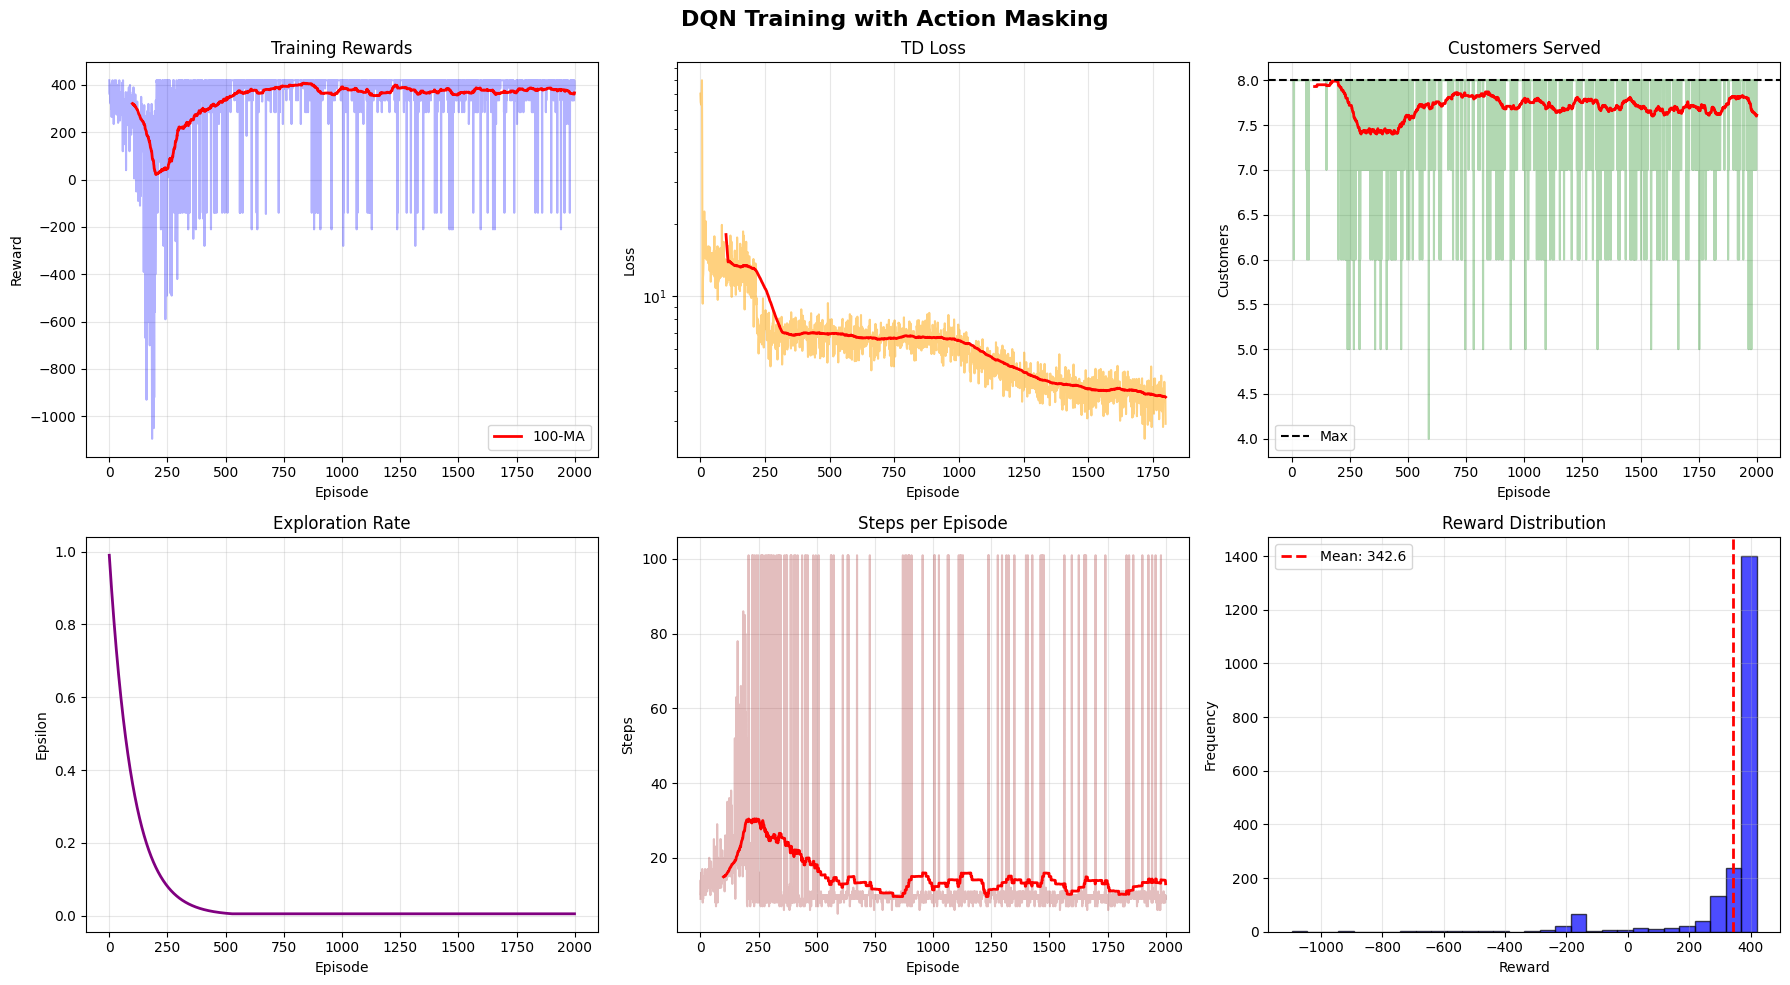

Episode visualization saved to 'dqn_baseline_episode.png'



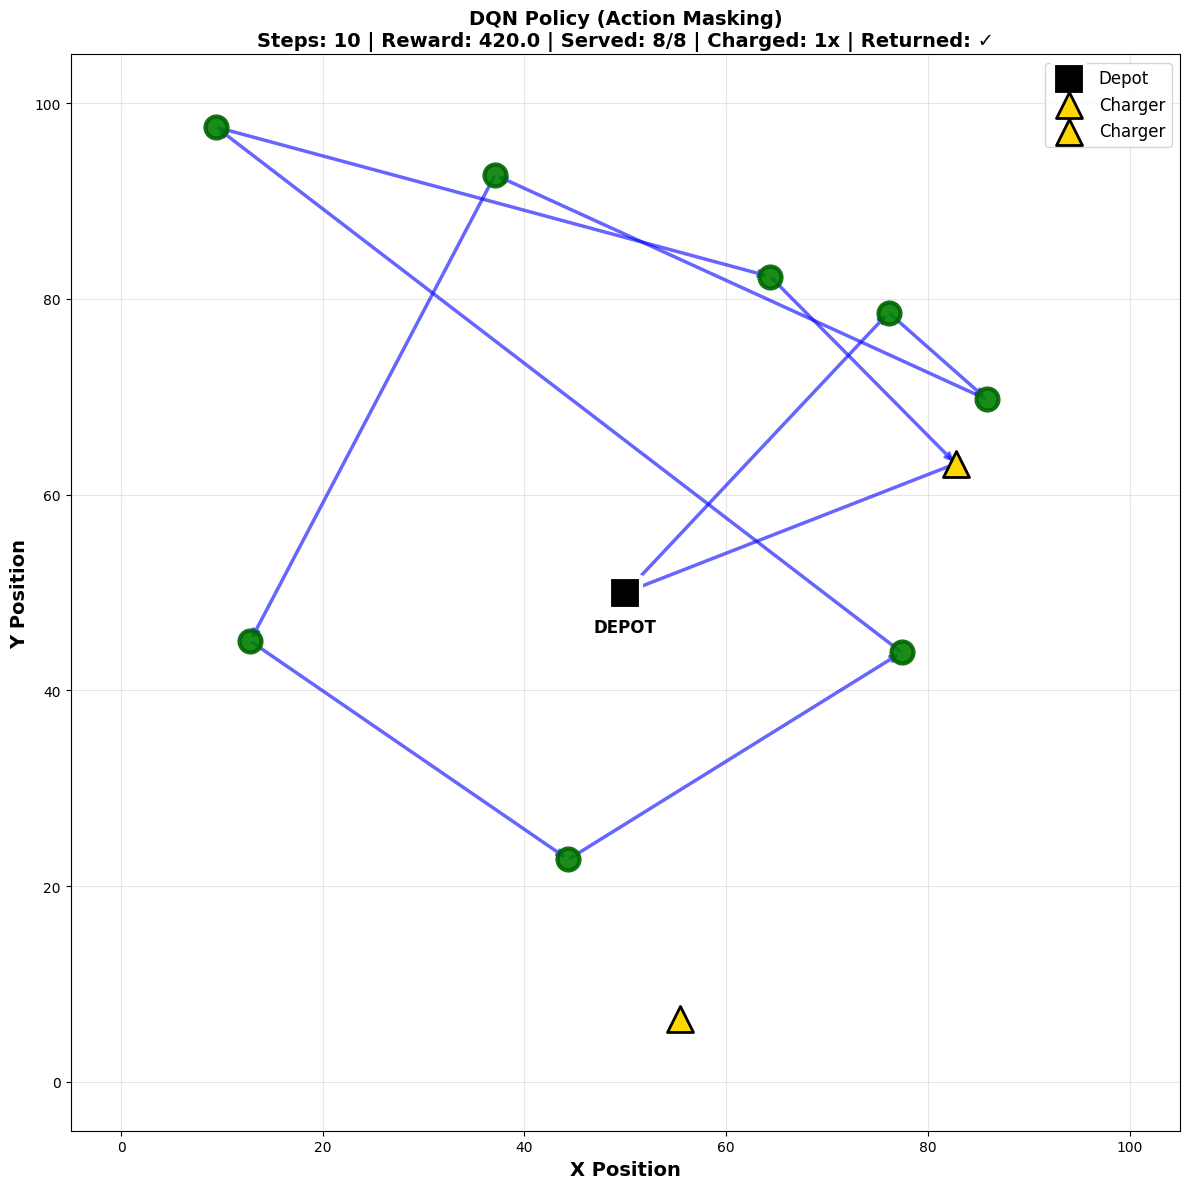

In [ ]:
# ============================================================================
# COMPREHENSIVE DQN vs DDQN TESTING SUITE
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------

# DQN Configuration
DQN_AGENT_CONFIG = {
    'learning_rate': 2e-3,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.005,
    'epsilon_decay': 0.990,
    'buffer_size': 150000,
    'batch_size': 512,
    'target_update_freq': 4,
    'polyak_tau': 0.015,
}

# DDQN Configuration (similar to DQN for fair comparison)
DDQN_AGENT_CONFIG = {
    'learning_rate': 2e-3,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.005,
    'epsilon_decay': 0.990,
    'buffer_size': 150000,
    'batch_size': 512,
    'target_update_freq': 4,
    'polyak_tau': 0.015,
    'dueling': False,  # Set to True to test Dueling DDQN
}

# Environment Configuration (8 customers, 2 chargers - more challenging)
ENV_CONFIG = SingleUAVConfig(
    num_customers=8,
    num_chargers=2,
    mission_time=800.0,
    battery_capacity=250.0,
    battery_per_meter=0.6,
    drone_speed=15.0,
    service_reward=50.0,
    charger_time_cost=1.0,
    recharge_rate=150.0,
    penalty_infeasible=15.0,
    penalty_repeat=5.0,
    penalty_tardiness=0.1,
    deadline_min=150.0,
    deadline_max=600.0,
    max_steps=100,
    deterministic_seed=42,
)

# Training parameters
NUM_EPISODES = 2000
LOG_INTERVAL = 50
WARMUP_EPISODES = 200
EVAL_EPISODES = 100

# ----------------------------------------------------------------------------
# TEST 1: Baseline DQN with Default Rewards
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 1: Baseline DQN with Default Rewards")
print("="*80 + "\n")

env_dqn_baseline = SingleUAVEnv(ENV_CONFIG)
trainer_dqn_baseline = SingleUAVDQNTrainer(env_dqn_baseline, DQN_AGENT_CONFIG)

dqn_baseline_rewards = trainer_dqn_baseline.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

dqn_baseline_eval = trainer_dqn_baseline.evaluate(num_episodes=EVAL_EPISODES)
trainer_dqn_baseline.plot_training_curves(save_path='dqn_baseline_curves.png')
trainer_dqn_baseline.visualize_episode(seed=42, save_path='dqn_baseline_episode.png')


TEST 2: Baseline DDQN with Default Rewards (Linear Weighted)


DDQN Trainer Initialization
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers
  Reward Shaper: LinearWeighted
  Dueling Network: False

TRAINING: 2000 episodes (warmup: 200)
Algorithm: Double DQN
Features: Action masking, LinearWeighted rewards

[WARMUP] Ep   50/2000 | R: 1142.4 | Loss:   nan | Cust: 7.7/8 | Steps: 13.8 | ε: 0.605
[WARMUP] Ep  100/2000 | R: 1221.4 | Loss:   nan | Cust: 7.8/8 | Steps: 11.4 | ε: 0.366
[WARMUP] Ep  150/2000 | R: 1101.8 | Loss:   nan | Cust: 7.7/8 | Steps: 19.2 | ε: 0.221
[WARMUP] Ep  200/2000 | R: 1053.4 | Loss:   nan | Cust: 7.6/8 | Steps: 19.6 | ε: 0.134
[TRAINING] Ep  250/2000 | R: 1050.7 | Loss: 18.56 | Cust: 7.5/8 | Steps: 19.4 | ε: 0.081
[TRAINING] Ep  300/2000 | R: 1084.3 | Loss:  9.31 | Cust: 7.6/8 | Steps: 20.2 | ε: 0.049
[TRAINING] Ep  350/2000 | R: 1193.3 | Loss:  9.42 | Cust: 7.7/8 | Steps: 13.1 | ε: 0.030
[TRAINING] Ep  400/2000 | R: 1117.0 | Los

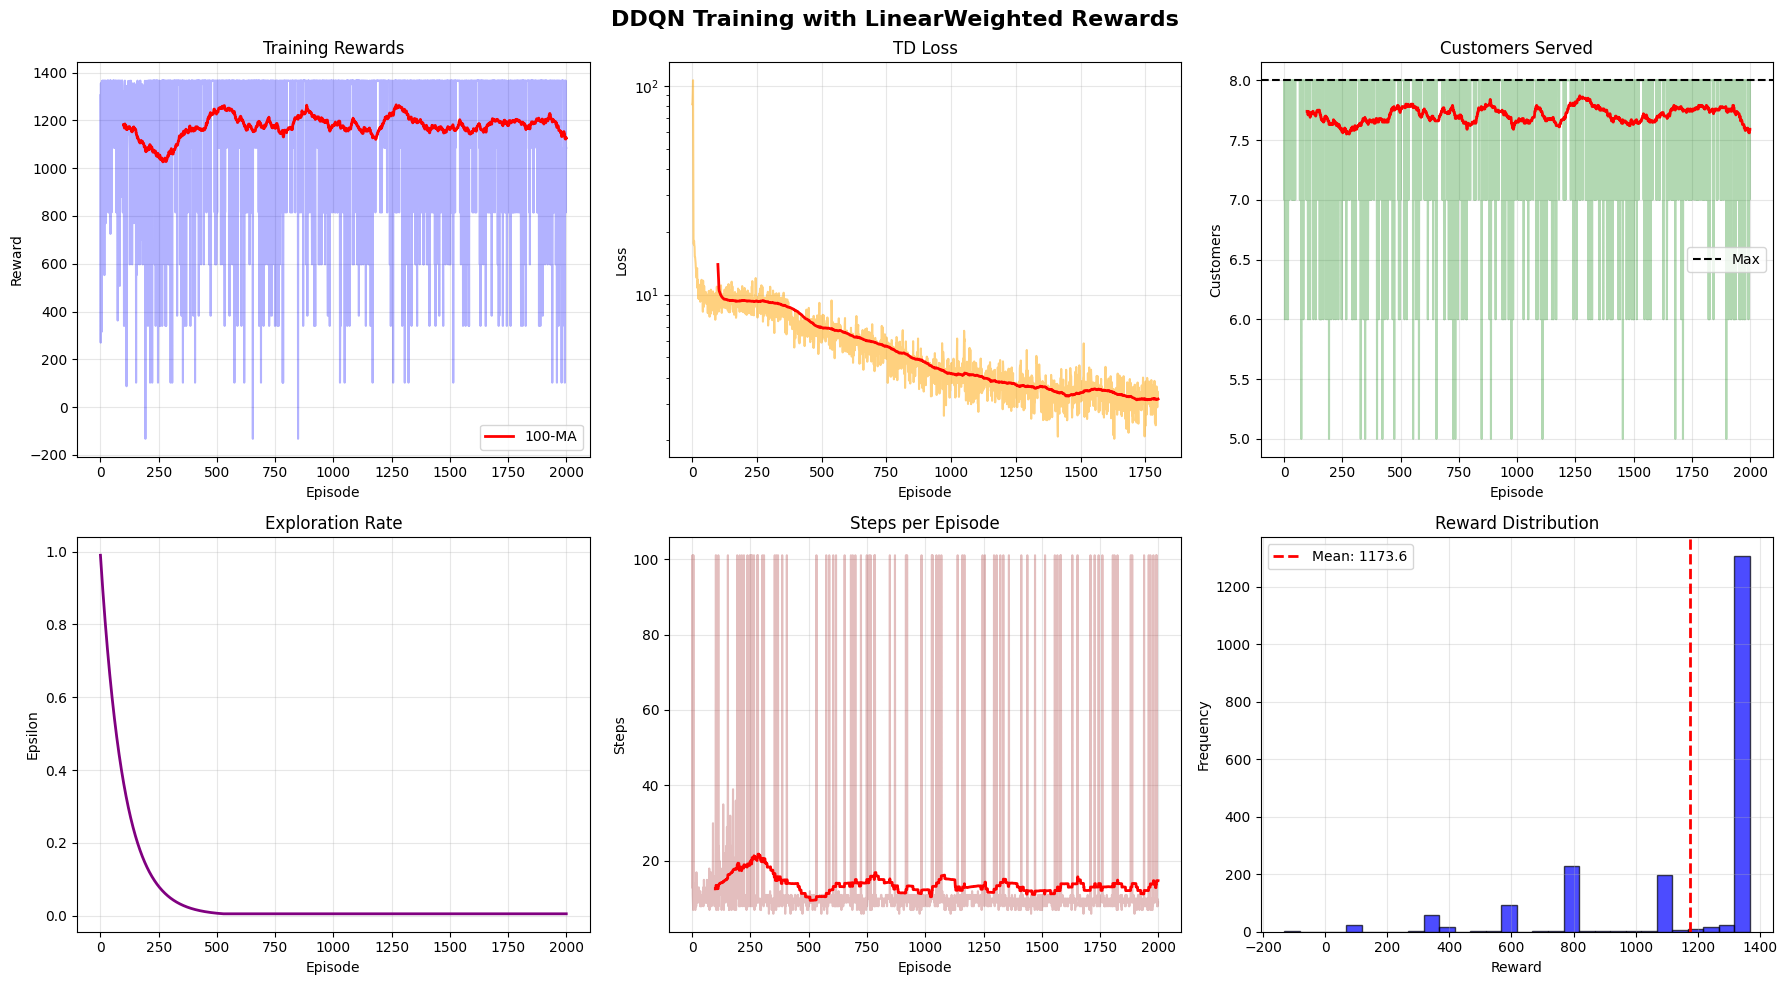

Episode visualization saved to 'ddqn_baseline_episode.png'



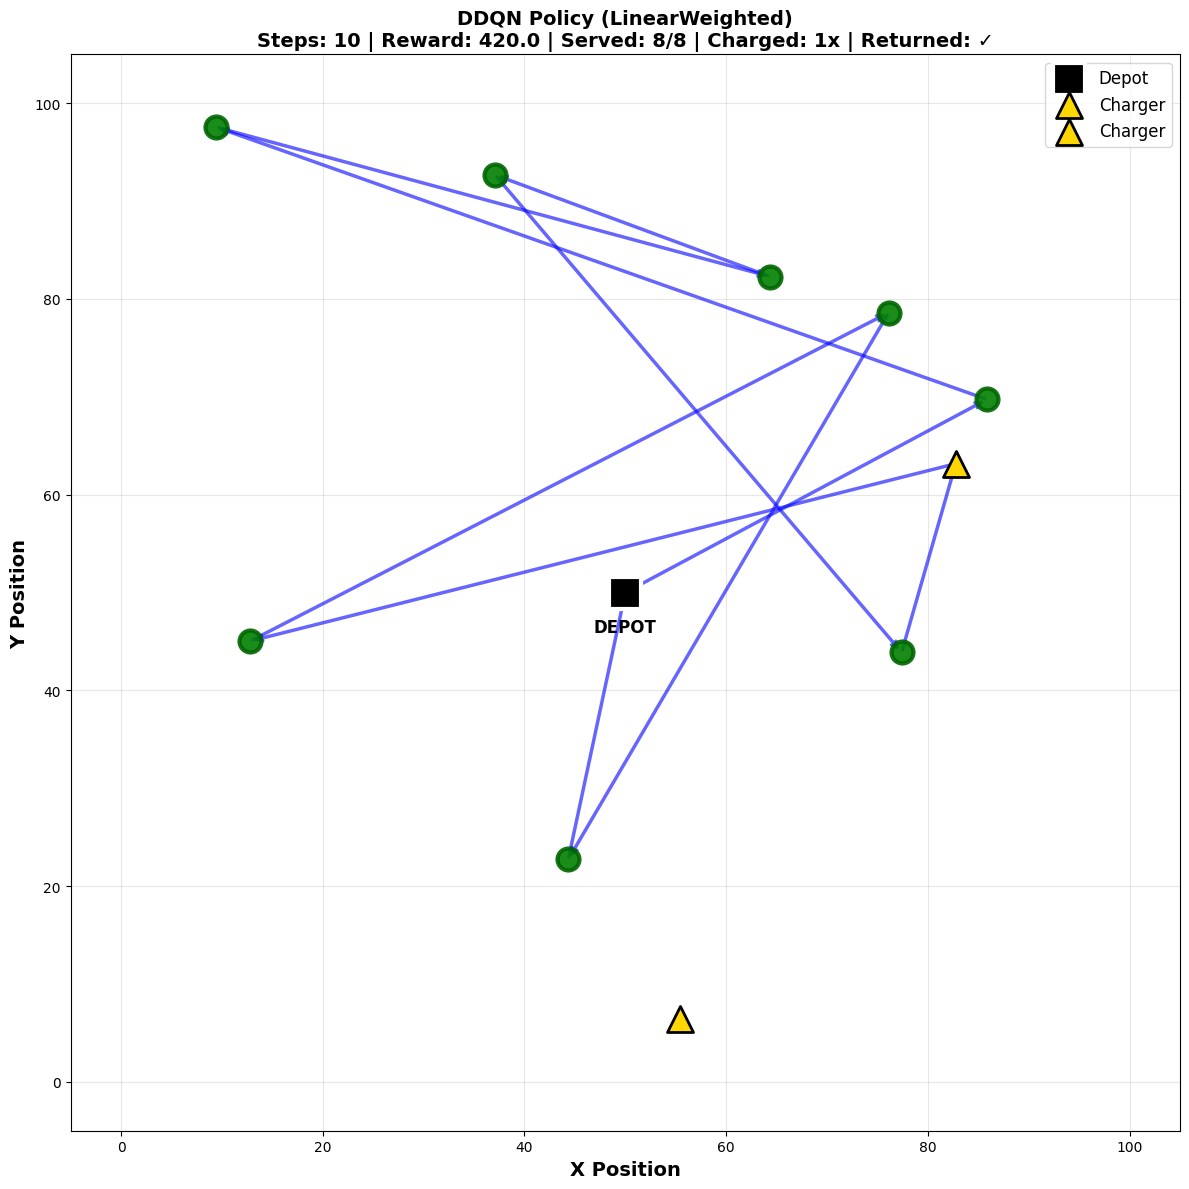


TEST 3: DDQN with Exponential Rewards


DDQN Trainer Initialization
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers
  Reward Shaper: NonLinearExponential
  Dueling Network: False

TRAINING: 2000 episodes (warmup: 200)
Algorithm: Double DQN
Features: Action masking, NonLinearExponential rewards

[WARMUP] Ep   50/2000 | R: 2006.9 | Loss:   nan | Cust: 7.7/8 | Steps: 17.1 | ε: 0.605
[WARMUP] Ep  100/2000 | R: 2175.8 | Loss:   nan | Cust: 7.9/8 | Steps: 17.4 | ε: 0.366
[WARMUP] Ep  150/2000 | R: 2204.2 | Loss:   nan | Cust: 8.0/8 | Steps: 18.6 | ε: 0.221
[WARMUP] Ep  200/2000 | R: 1970.2 | Loss:   nan | Cust: 8.0/8 | Steps: 31.1 | ε: 0.134
[TRAINING] Ep  250/2000 | R: 1809.4 | Loss: 16.12 | Cust: 7.5/8 | Steps: 21.9 | ε: 0.081
[TRAINING] Ep  300/2000 | R: 1839.4 | Loss:  9.11 | Cust: 7.5/8 | Steps: 20.6 | ε: 0.049
[TRAINING] Ep  350/2000 | R: 1929.8 | Loss:  6.01 | Cust: 7.6/8 | Steps: 16.3 | ε: 0.030
[TRAINING] Ep  400/2000 | R: 1717.8 | Loss:  6.13 | 

In [ ]:
# ----------------------------------------------------------------------------
# TEST 2: Baseline DDQN with Default Rewards
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 2: Baseline DDQN with Default Rewards (Linear Weighted)")
print("="*80 + "\n")

env_ddqn_baseline = SingleUAVEnv(ENV_CONFIG)
reward_shaper_baseline = LinearWeightedReward(env_ddqn_baseline)
trainer_ddqn_baseline = SingleUAVDDQNTrainer(
    env_ddqn_baseline,
    config=DDQN_AGENT_CONFIG,
    reward_shaper=reward_shaper_baseline
)

ddqn_baseline_rewards = trainer_ddqn_baseline.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

ddqn_baseline_eval = trainer_ddqn_baseline.evaluate(num_episodes=EVAL_EPISODES)
trainer_ddqn_baseline.plot_training_curves(save_path='ddqn_baseline_curves.png')
trainer_ddqn_baseline.visualize_episode(seed=42, save_path='ddqn_baseline_episode.png')

# ----------------------------------------------------------------------------
# TEST 3: DDQN with Exponential Rewards
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 3: DDQN with Exponential Rewards")
print("="*80 + "\n")

env_ddqn_exp = SingleUAVEnv(ENV_CONFIG)
reward_shaper_exp = NonLinearExponentialReward(
    env_ddqn_exp,
    base_multiplier=2.0,
    exp_factor=1.5
)
trainer_ddqn_exp = SingleUAVDDQNTrainer(
    env_ddqn_exp,
    config=DDQN_AGENT_CONFIG,
    reward_shaper=reward_shaper_exp
)

ddqn_exp_rewards = trainer_ddqn_exp.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

ddqn_exp_eval = trainer_ddqn_exp.evaluate(num_episodes=EVAL_EPISODES)

In [ ]:
# ----------------------------------------------------------------------------
# TEST 4: DDQN with Sigmoid Rewards
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 4: DDQN with Sigmoid Rewards")
print("="*80 + "\n")

env_ddqn_sigmoid = SingleUAVEnv(ENV_CONFIG)
reward_shaper_sigmoid = NonLinearSigmoidReward(
    env_ddqn_sigmoid,
    steepness=10.0,
    midpoint=0.5
)
trainer_ddqn_sigmoid = SingleUAVDDQNTrainer(
    env_ddqn_sigmoid,
    config=DDQN_AGENT_CONFIG,
    reward_shaper=reward_shaper_sigmoid
)

ddqn_sigmoid_rewards = trainer_ddqn_sigmoid.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

ddqn_sigmoid_eval = trainer_ddqn_sigmoid.evaluate(num_episodes=EVAL_EPISODES)

# ----------------------------------------------------------------------------
# TEST 5: DDQN with Adaptive Rewards
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 5: DDQN with Adaptive Dynamic Rewards")
print("="*80 + "\n")

env_ddqn_adaptive = SingleUAVEnv(ENV_CONFIG)
trainer_ddqn_adaptive = SingleUAVDDQNTrainer(
    env_ddqn_adaptive,
    config=DDQN_AGENT_CONFIG,
    reward_shaper=AdaptiveDynamicReward
)

ddqn_adaptive_rewards = trainer_ddqn_adaptive.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

ddqn_adaptive_eval = trainer_ddqn_adaptive.evaluate(num_episodes=EVAL_EPISODES)

# ----------------------------------------------------------------------------
# TEST 6: DDQN with Custom Weighted Rewards (Optimized for 8 customers)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 6: DDQN with Custom Weighted Rewards (Completion-Focused)")
print("="*80 + "\n")

env_ddqn_custom = SingleUAVEnv(ENV_CONFIG)

# Custom weights optimized for 8-customer problem
custom_weights = {
    'new_customer': 100.0,           # High reward per customer
    'completion_bonus': 600.0,       # Massive bonus for completing all 8
    'completion_no_return': 200.0,   # Partial credit
    'return_penalty': 100.0,         # Strong penalty for no return
    'incomplete_per_customer': 150.0,  # HARSH - 8 customers makes this critical
    'early_quit_penalty': 200.0,     # Don't give up!
    'progress_bonus': 50.0,          # Good incremental encouragement
    'time_efficiency_bonus': 80.0,   # Reward efficiency
}

reward_shaper_custom = LinearWeightedReward(env_ddqn_custom, weights=custom_weights)
trainer_ddqn_custom = SingleUAVDDQNTrainer(
    env_ddqn_custom,
    config=DDQN_AGENT_CONFIG,
    reward_shaper=reward_shaper_custom
)

ddqn_custom_rewards = trainer_ddqn_custom.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

ddqn_custom_eval = trainer_ddqn_custom.evaluate(num_episodes=EVAL_EPISODES)


TEST 4: DDQN with Sigmoid Rewards


DDQN Trainer Initialization
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers
  Reward Shaper: NonLinearSigmoid
  Dueling Network: False

TRAINING: 2000 episodes (warmup: 200)
Algorithm: Double DQN
Features: Action masking, NonLinearSigmoid rewards

[WARMUP] Ep   50/2000 | R:  918.0 | Loss:   nan | Cust: 7.8/8 | Steps: 16.1 | ε: 0.605
[WARMUP] Ep  100/2000 | R:  828.7 | Loss:   nan | Cust: 8.0/8 | Steps: 21.2 | ε: 0.366
[WARMUP] Ep  150/2000 | R:  667.8 | Loss:   nan | Cust: 8.0/8 | Steps: 28.5 | ε: 0.221
[WARMUP] Ep  200/2000 | R:  168.9 | Loss:   nan | Cust: 8.0/8 | Steps: 49.2 | ε: 0.134
[TRAINING] Ep  250/2000 | R:  827.2 | Loss: 25.10 | Cust: 7.5/8 | Steps: 15.7 | ε: 0.081
[TRAINING] Ep  300/2000 | R:  743.1 | Loss: 13.97 | Cust: 7.5/8 | Steps: 26.8 | ε: 0.049
[TRAINING] Ep  350/2000 | R:  791.0 | Loss: 13.45 | Cust: 7.6/8 | Steps: 27.0 | ε: 0.030
[TRAINING] Ep  400/2000 | R:  800.4 | Loss: 12.09 | Cust: 7.6/8 


TEST 7: Dueling DDQN with Custom Weighted Rewards


DDQN Trainer Initialization
  State dimension: 41
  Action dimension: 11
  Environment: 8 customers, 2 chargers
  Reward Shaper: LinearWeighted
  Dueling Network: True

TRAINING: 2000 episodes (warmup: 200)
Algorithm: Double DQN
Features: Action masking, LinearWeighted rewards

[WARMUP] Ep   50/2000 | R: 2213.9 | Loss:   nan | Cust: 7.8/8 | Steps: 13.7 | ε: 0.605
[WARMUP] Ep  100/2000 | R: 2158.3 | Loss:   nan | Cust: 7.8/8 | Steps: 20.8 | ε: 0.366
[WARMUP] Ep  150/2000 | R: 2056.5 | Loss:   nan | Cust: 7.9/8 | Steps: 25.7 | ε: 0.221
[WARMUP] Ep  200/2000 | R: 1666.4 | Loss:   nan | Cust: 8.0/8 | Steps: 40.4 | ε: 0.134
[TRAINING] Ep  250/2000 | R: 1930.1 | Loss:  8.97 | Cust: 7.6/8 | Steps: 25.6 | ε: 0.081
[TRAINING] Ep  300/2000 | R: 1994.6 | Loss:  6.21 | Cust: 7.6/8 | Steps: 14.6 | ε: 0.049
[TRAINING] Ep  350/2000 | R: 1947.5 | Loss:  6.84 | Cust: 7.5/8 | Steps: 18.1 | ε: 0.030
[TRAINING] Ep  400/2000 | R: 2054.4 | Loss:  6.96 | C

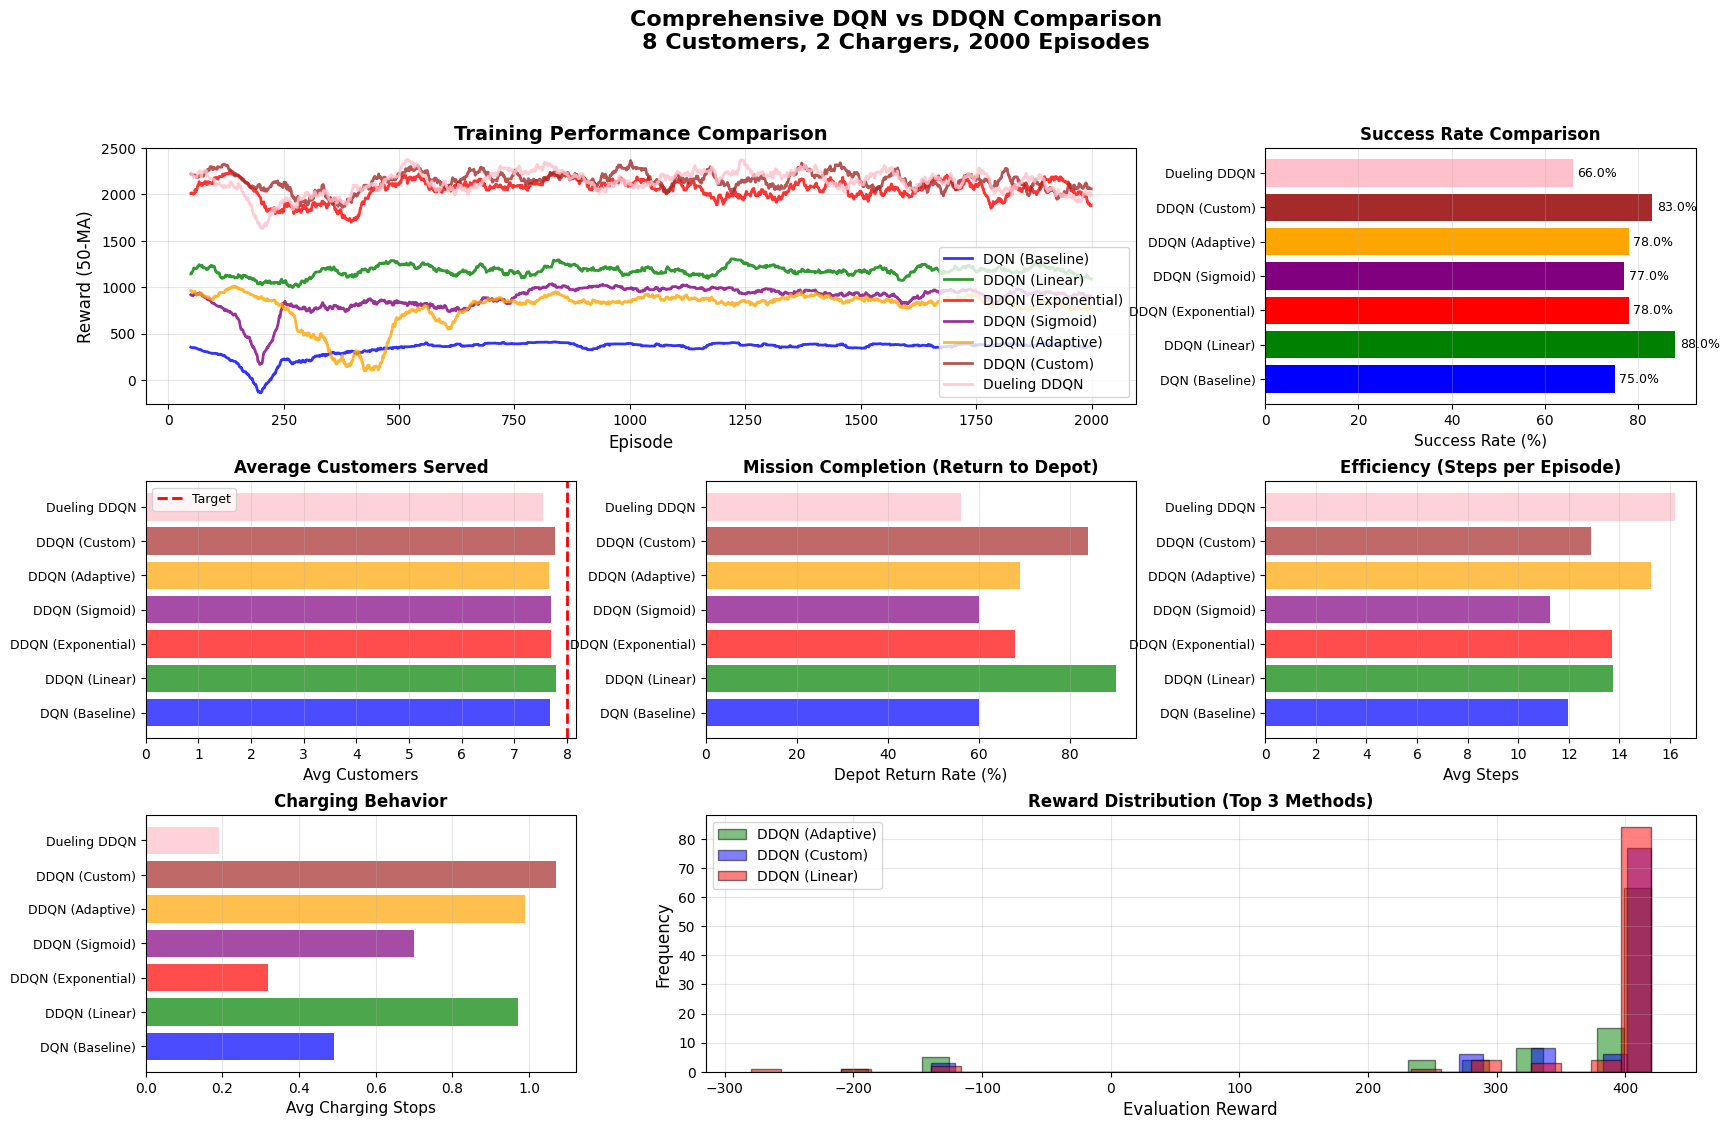

In [ ]:
# ----------------------------------------------------------------------------
# TEST 7: Dueling DDQN with Best Reward Function
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("TEST 7: Dueling DDQN with Custom Weighted Rewards")
print("="*80 + "\n")

env_dueling = SingleUAVEnv(ENV_CONFIG)

# Enable dueling architecture
DUELING_CONFIG = DDQN_AGENT_CONFIG.copy()
DUELING_CONFIG['dueling'] = True
DUELING_CONFIG['learning_rate'] = 1e-3  # Slightly lower for dueling

reward_shaper_dueling = LinearWeightedReward(env_dueling, weights=custom_weights)
trainer_dueling = SingleUAVDDQNTrainer(
    env_dueling,
    config=DUELING_CONFIG,
    reward_shaper=reward_shaper_dueling
)

dueling_rewards = trainer_dueling.train(
    num_episodes=NUM_EPISODES,
    log_interval=LOG_INTERVAL,
    warmup_episodes=WARMUP_EPISODES
)

dueling_eval = trainer_dueling.evaluate(num_episodes=EVAL_EPISODES)

# ----------------------------------------------------------------------------
# COMPREHENSIVE RESULTS COMPARISON
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80 + "\n")

# Collect all results
results = {
    'DQN (Baseline)': {
        'rewards': dqn_baseline_rewards,
        'eval': dqn_baseline_eval,
    },
    'DDQN (Linear)': {
        'rewards': ddqn_baseline_rewards,
        'eval': ddqn_baseline_eval,
    },
    'DDQN (Exponential)': {
        'rewards': ddqn_exp_rewards,
        'eval': ddqn_exp_eval,
    },
    'DDQN (Sigmoid)': {
        'rewards': ddqn_sigmoid_rewards,
        'eval': ddqn_sigmoid_eval,
    },
    'DDQN (Adaptive)': {
        'rewards': ddqn_adaptive_rewards,
        'eval': ddqn_adaptive_eval,
    },
    'DDQN (Custom)': {
        'rewards': ddqn_custom_rewards,
        'eval': ddqn_custom_eval,
    },
    'Dueling DDQN': {
        'rewards': dueling_rewards,
        'eval': dueling_eval,
    },
}

# Print detailed comparison
for name, data in results.items():
    eval_data = data['eval']
    success_rate = np.sum(np.array(eval_data['customers_served']) == ENV_CONFIG.num_customers) / EVAL_EPISODES * 100

    print(f"{name}:")
    print(f"  Final Training Reward (last 100): {np.mean(data['rewards'][-100:]):8.1f}")
    print(f"  Eval Reward:                       {np.mean(eval_data['rewards']):8.1f} ± {np.std(eval_data['rewards']):.1f}")
    print(f"  Customers Served:                  {np.mean(eval_data['customers_served']):5.1f}/{ENV_CONFIG.num_customers}")
    print(f"  Success Rate:                      {success_rate:5.1f}%")
    print(f"  Depot Return Rate:                 {np.mean(eval_data['returned'])*100:5.1f}%")
    print(f"  Avg Charging Stops:                {np.mean(eval_data['charged']):5.1f}")
    print(f"  Avg Steps:                         {np.mean(eval_data['steps']):5.1f} ± {np.std(eval_data['steps']):.1f}")
    print()

# ----------------------------------------------------------------------------
# VISUALIZATION: Comprehensive Comparison Plots
# ----------------------------------------------------------------------------
print("Creating comprehensive comparison plots...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training Rewards (Moving Average)
ax1 = fig.add_subplot(gs[0, :2])
window = 50
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
for (name, data), color in zip(results.items(), colors):
    rewards = data['rewards']
    if len(rewards) >= window:
        ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(rewards)), ma, label=name, linewidth=2, color=color, alpha=0.8)
ax1.set_xlabel('Episode', fontsize=12)
ax1.set_ylabel('Reward (50-MA)', fontsize=12)
ax1.set_title('Training Performance Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# 2. Success Rates
ax2 = fig.add_subplot(gs[0, 2])
names = list(results.keys())
success_rates = [
    np.sum(np.array(results[n]['eval']['customers_served']) == ENV_CONFIG.num_customers) / EVAL_EPISODES * 100
    for n in names
]
bars = ax2.barh(range(len(names)), success_rates, color=colors)
ax2.set_yticks(range(len(names)))
ax2.set_yticklabels(names, fontsize=9)
ax2.set_xlabel('Success Rate (%)', fontsize=11)
ax2.set_title('Success Rate Comparison', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars, success_rates)):
    ax2.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=9)

# 3. Average Customers Served
ax3 = fig.add_subplot(gs[1, 0])
avg_customers = [np.mean(results[n]['eval']['customers_served']) for n in names]
ax3.barh(range(len(names)), avg_customers, color=colors, alpha=0.7)
ax3.set_yticks(range(len(names)))
ax3.set_yticklabels(names, fontsize=9)
ax3.set_xlabel('Avg Customers', fontsize=11)
ax3.set_title('Average Customers Served', fontsize=12, fontweight='bold')
ax3.axvline(x=ENV_CONFIG.num_customers, color='red', linestyle='--', linewidth=2, label='Target')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3, axis='x')

# 4. Depot Return Rates
ax4 = fig.add_subplot(gs[1, 1])
return_rates = [np.mean(results[n]['eval']['returned']) * 100 for n in names]
ax4.barh(range(len(names)), return_rates, color=colors, alpha=0.7)
ax4.set_yticks(range(len(names)))
ax4.set_yticklabels(names, fontsize=9)
ax4.set_xlabel('Depot Return Rate (%)', fontsize=11)
ax4.set_title('Mission Completion (Return to Depot)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='x')

# 5. Average Steps
ax5 = fig.add_subplot(gs[1, 2])
avg_steps = [np.mean(results[n]['eval']['steps']) for n in names]
ax5.barh(range(len(names)), avg_steps, color=colors, alpha=0.7)
ax5.set_yticks(range(len(names)))
ax5.set_yticklabels(names, fontsize=9)
ax5.set_xlabel('Avg Steps', fontsize=11)
ax5.set_title('Efficiency (Steps per Episode)', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3, axis='x')

# 6. Charging Behavior
ax6 = fig.add_subplot(gs[2, 0])
avg_charges = [np.mean(results[n]['eval']['charged']) for n in names]
ax6.barh(range(len(names)), avg_charges, color=colors, alpha=0.7)
ax6.set_yticks(range(len(names)))
ax6.set_yticklabels(names, fontsize=9)
ax6.set_xlabel('Avg Charging Stops', fontsize=11)
ax6.set_title('Charging Behavior', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3, axis='x')

# 7. Reward Distribution (Best 3 methods)
ax7 = fig.add_subplot(gs[2, 1:])
# Find top 3 by success rate
top_3_indices = np.argsort(success_rates)[-3:]
top_3_names = [names[i] for i in top_3_indices]
for name, color in zip(top_3_names, ['green', 'blue', 'red']):
    eval_rewards = results[name]['eval']['rewards']
    ax7.hist(eval_rewards, bins=30, alpha=0.5, label=name, color=color, edgecolor='black')
ax7.set_xlabel('Evaluation Reward', fontsize=12)
ax7.set_ylabel('Frequency', fontsize=12)
ax7.set_title('Reward Distribution (Top 3 Methods)', fontsize=12, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(alpha=0.3)

plt.suptitle(f'Comprehensive DQN vs DDQN Comparison\n{ENV_CONFIG.num_customers} Customers, {ENV_CONFIG.num_chargers} Chargers, {NUM_EPISODES} Episodes',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('comprehensive_comparison.png', dpi=150, bbox_inches='tight')
print("Comprehensive comparison plot saved to 'comprehensive_comparison.png'")
plt.show()

In [ ]:
# ----------------------------------------------------------------------------
# FINAL RECOMMENDATIONS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80 + "\n")

best_idx = np.argmax(success_rates)
best_method = names[best_idx]

print(f"🏆 Best Overall Method: {best_method}")
print(f"   Success Rate: {success_rates[best_idx]:.1f}%")
print(f"   Avg Reward: {np.mean(results[best_method]['eval']['rewards']):.1f}")
print()

# Performance tiers
print("Performance Tiers:")
for i, (name, rate) in enumerate(zip(names, success_rates), 1):
    tier = "🥇 Excellent" if rate >= 80 else "🥈 Good" if rate >= 60 else "🥉 Fair" if rate >= 40 else "❌ Needs Work"
    print(f"  {i}. {name:25s} - {rate:5.1f}% - {tier}")

print("\n" + "="*80)
print("Key Insights:")
print("="*80)
print("• DDQN typically reduces overestimation bias compared to DQN")
print("• Custom weighted rewards often outperform default shaping")
print("• Exponential rewards work well for encouraging mission completion")
print("• Adaptive rewards can provide good balance across training phases")
print("• Dueling architecture can improve performance on complex state spaces")
print("• For 8 customers, strong completion incentives are critical")
print("="*80 + "\n")

# Save detailed results to file
with open('detailed_results.txt', 'w') as f:
    f.write("DETAILED EXPERIMENTAL RESULTS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Environment: {ENV_CONFIG.num_customers} customers, {ENV_CONFIG.num_chargers} chargers\n")
    f.write(f"Training: {NUM_EPISODES} episodes, {WARMUP_EPISODES} warmup\n")
    f.write(f"Evaluation: {EVAL_EPISODES} episodes\n\n")

    for name, data in results.items():
        f.write(f"\n{name}\n")
        f.write("-"*40 + "\n")
        eval_data = data['eval']
        success_rate = np.sum(np.array(eval_data['customers_served']) == ENV_CONFIG.num_customers) / EVAL_EPISODES * 100

        f.write(f"Training Reward (final 100): {np.mean(data['rewards'][-100:]):.2f}\n")
        f.write(f"Eval Reward: {np.mean(eval_data['rewards']):.2f} ± {np.std(eval_data['rewards']):.2f}\n")
        f.write(f"Customers: {np.mean(eval_data['customers_served']):.2f}/{ENV_CONFIG.num_customers}\n")
        f.write(f"Success Rate: {success_rate:.2f}%\n")
        f.write(f"Depot Return: {np.mean(eval_data['returned'])*100:.2f}%\n")
        f.write(f"Charging Stops: {np.mean(eval_data['charged']):.2f}\n")
        f.write(f"Steps: {np.mean(eval_data['steps']):.2f} ± {np.std(eval_data['steps']):.2f}\n")

print("Detailed results saved to 'detailed_results.txt'")
print("\n🎉 All tests complete! Check the generated plots and results file.")


RECOMMENDATIONS

🏆 Best Overall Method: DDQN (Linear)
   Success Rate: 88.0%
   Avg Reward: 381.6

Performance Tiers:
  1. DQN (Baseline)            -  75.0% - 🥈 Good
  2. DDQN (Linear)             -  88.0% - 🥇 Excellent
  3. DDQN (Exponential)        -  78.0% - 🥈 Good
  4. DDQN (Sigmoid)            -  77.0% - 🥈 Good
  5. DDQN (Adaptive)           -  78.0% - 🥈 Good
  6. DDQN (Custom)             -  83.0% - 🥇 Excellent
  7. Dueling DDQN              -  66.0% - 🥈 Good

Key Insights:
• DDQN typically reduces overestimation bias compared to DQN
• Custom weighted rewards often outperform default shaping
• Exponential rewards work well for encouraging mission completion
• Adaptive rewards can provide good balance across training phases
• Dueling architecture can improve performance on complex state spaces
• For 8 customers, strong completion incentives are critical

Detailed results saved to 'detailed_results.txt'

🎉 All tests complete! Check the generated plots and results file.
